In [1]:
import sys
from pathlib import Path
import os
import warnings
import time
import re
SPIKECOUNTER_PATH = os.getenv("SPIKECOUNTER_PATH")
ANALYSIS_OUTPUT_ROOTDIR = os.getenv("ANALYSIS_OUTPUT_ROOTDIR")
DATA_ROOTDIR = os.getenv("DATA_ROOTDIR")
sys.path.append(SPIKECOUNTER_PATH)

import matplotlib.pyplot as plt
from scipy import signal, interpolate, optimize, stats
import scipy.io as scio
import numpy as np
import os
import matplotlib.cm as cm
import matplotlib.colors as colors
import colorcet as cc
import pickle
from parse import *
import seaborn as sbs
import time
import copy


from spikecounter.analysis import traces, images
from spikecounter import utils
from spikecounter.ui import visualize
from spikecounter.analysis import stats as sc_stats
from sklearn import neighbors
import lmfit
from cycler import cycler
import pandas as pd
import importlib
from statannotations.Annotator import Annotator

warnings.filterwarnings("once")
biopubs_style = os.path.join(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
plt.style.use(
    biopubs_style
)

In [3]:
rootdir = "/n/holyscratch01/cohen_lab/bjia/20220924_0D_MorrisLecar_v3/"
figdir = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat/Figures/"
cm_string = "cet_CET_R1"
cmap = cm.get_cmap(cm_string)

In [4]:
def round_rel_deviation(arr, factor=100):
    try:
        n_decimals = -int(np.floor(np.min(np.log10(np.abs(arr[arr!=0])/factor))))
    except ValueError:
        n_decimals = 1
    rounded = np.round(arr, n_decimals)
#     print(arr, n_decimals, rounded)
    return rounded

In [5]:
all_data = pd.read_csv(os.path.join(rootdir, "subcritical_hopf_stringent.csv")).set_index("bifurcation")

In [6]:
rootdir_expt = "/n/cohen_lab/Lab/Labmembers/Bill Jia/Data/Firefly/"
expts = ["20210420_gcamp_widefield", \
         "20210716_gcamp_widefield", "20210724_gcamp_widefield"]
datadirs = [os.path.join(rootdir_expt, d) for d in expts]
expt_moments = []
for datadir in datadirs:
    expt_moments.append(scio.loadmat(os.path.join(datadir, "", "analysis/all_moments.mat")))

In [7]:
unaligned_frequencies = []
unaligned_covs = []
all_index_offsets = []
for i in range(len(expt_moments)):
    moments = expt_moments[i]
    unaligned_frequencies.append(moments["all_freqs"])
    unaligned_covs.append(moments["covs"])
    all_index_offsets.append(moments["idx_offsets"].ravel())
dt = moments["hpf"].ravel()[1]-moments["hpf"].ravel()[0]
aligned_frequencies, global_time_freq = utils.align_traces(unaligned_frequencies, all_index_offsets)
aligned_covs, _ = utils.align_traces(unaligned_covs, all_index_offsets)
time_rel_offset = global_time_freq*dt

In [8]:
index_cutoffs = np.ones(aligned_covs.shape[0], dtype=int)*aligned_covs.shape[1]
index_cutoffs[0] = 1100
index_cutoffs[1] = 1125

index_cutoffs[4] = 1220
index_cutoffs[5] = 1180

index_cutoffs[6] = 1250
index_cutoffs[7] = 1100
index_cutoffs[8] = 1150

index_cutoffs[9] = 1300
index_cutoffs[10] = 1250
index_cutoffs[11] = 1250
index_cutoffs[12] = 1000

index_cutoffs[18] = 1100
index_cutoffs[19] = 1220
index_cutoffs[20] = 950
index_cutoffs[21] = 1000

for i in range(aligned_frequencies.shape[0]):
    if index_cutoffs[i] < aligned_frequencies.shape[1]:
        aligned_frequencies[i,index_cutoffs[i]:] = np.nan
        aligned_covs[i,index_cutoffs[i]:] = np.nan

In [9]:
det_bifurcation_points = {"snic": 4.68, "saddle_node": 4.68, "supercritical_hopf": 14.61, "subcritical_hopf": 48.91}

In [10]:
freq_mats = []
cov_mats = []
for i in range(3):
    moments = expt_moments[i]
    freq_mats.append(moments["all_freqs"])
    cov_mats.append(moments["covs"])

n_embryos = [fm.shape[0] for fm in freq_mats]
n_embryos_cumulative = np.cumsum([0] + n_embryos)
max_duration_freq = np.max([fm.shape[1] for fm in freq_mats])
max_duration_cov = np.max([covmat.shape[1] for covmat in cov_mats])

all_expt_freqs = np.nan*np.ones((n_embryos_cumulative[-1], max_duration_freq))
ecov = np.nan*np.ones((n_embryos_cumulative[-1], max_duration_cov))
for i in range(len(freq_mats)):
    fm = freq_mats[i]
    covmat = cov_mats[i]
    all_expt_freqs[n_embryos_cumulative[i]:n_embryos_cumulative[i+1],:fm.shape[1]] = fm
    ecov[n_embryos_cumulative[i]:n_embryos_cumulative[i+1], :covmat.shape[1]] = covmat

In [11]:
def central_diff4(y):
    try:
        diff_start = y[1] - y[0]
        diff_end = y[-1] - y[-2]
        y_aug = np.concatenate([[y[0] - 2*diff_start, y[0] -diff_start], y, [y[-1] + diff_start, y[-1]+ 2*diff_start]])
        d1 = -np.roll(y_aug,2) + 8*np.roll(y_aug,1) - 8*np.roll(y_aug,-1) + np.roll(y_aug, -2)
        d1 = d1[2:-2]
    except Exception as e:
        print(y)
        raise e
    return d1

In [12]:
bif_data = all_data.loc["snic"]
f = pd.pivot_table(bif_data, values="freq", index="sigma", columns=["I"], dropna=False)
covs = pd.pivot_table(bif_data, values="isi_cv", index="sigma", columns=["I"], dropna=False)
sigmas = f.index.to_numpy()
n_valid = np.sum(~np.isnan(aligned_frequencies), axis=1)
characteristic_scale_bif = {"snic":1/np.mean(n_valid), "saddle_node":1/np.mean(n_valid), \
                            "supercritical_hopf": 3/np.mean(n_valid), "subcritical_hopf": 5/np.mean(n_valid)}
scale_factors_bif = {"snic": [500,1/0.1,10], "saddle_node": [500,1/0.45,10],\
                     "supercritical_hopf": [100,1/0.15,1], "subcritical_hopf": [100,1/0.18,0.5]}

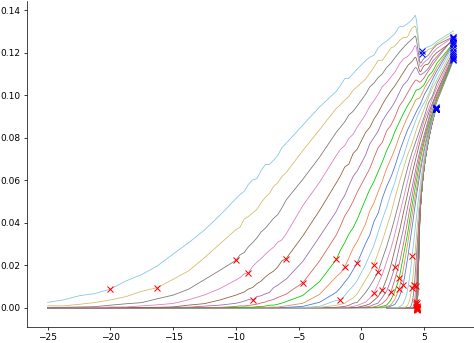

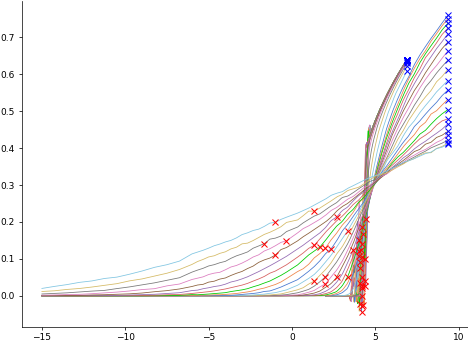

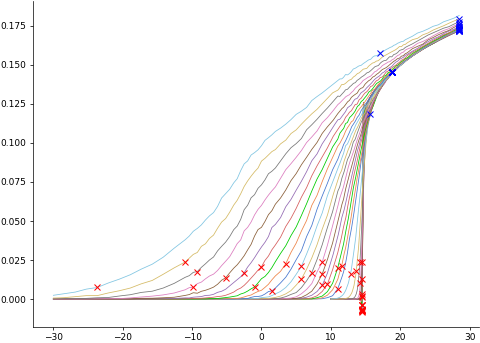

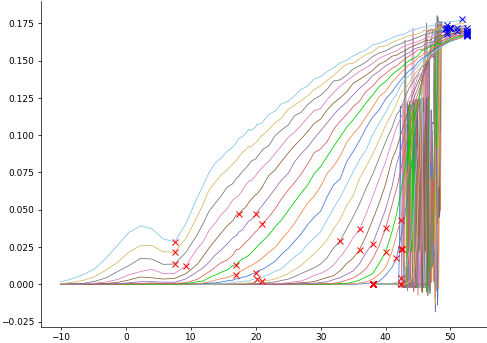

In [99]:
max_diffs = {}
min_diffs = {}

for bif in ["snic", "saddle_node", "supercritical_hopf", "subcritical_hopf"]:
# for bif in ["snic"]:
    bif_data = all_data.loc[bif]
    f = pd.pivot_table(bif_data, values="freq", index="sigma", columns=["I"], dropna=False)
    covs = pd.pivot_table(bif_data, values="isi_cv", index="sigma", columns=["I"], dropna=False)
    sigmas = f.index.to_numpy()
    rs = f.columns.to_numpy()
    f_sim = f.to_numpy()
    cov_sim = covs.to_numpy()
    
    
    dr = 0.01
    interp_functions = np.apply_along_axis(lambda x: interpolate.interp1d(rs[np.isfinite(x)], x[np.isfinite(x)],\
                                        bounds_error=False), 1, f_sim)
    eq_sp_rs = list(map(lambda x: np.arange(np.min(rs[np.isfinite(x)]), np.max(rs[np.isfinite(x)]), step=dr), f_sim))
    f_interp1 = list(map(lambda x,y: x(y), list(interp_functions), eq_sp_rs))
    
    f_interp_smoothed = list(map(lambda x: signal.savgol_filter(x, 35, 3), f_interp1))
    interp_functions2 = list(map(lambda x,y: interpolate.interp1d(x, y, bounds_error=False), eq_sp_rs, f_interp_smoothed))
    f_interp = np.array(list(map(lambda x: x(rs), interp_functions2)))

    d1 = list(map(central_diff4, f_interp_smoothed))
    d2 = list(map(central_diff4, d1))
    
    if bif == "snic":
        idx = 31
#         max_diff_f_interp = list(map(lambda x, y, z: x[np.nanargmax(y[(z<0.025)&(x<5)])], eq_sp_rs[:idx], d2[:idx],\
#                                 f_interp_smoothed[:idx])) + \
#         list(map(lambda x, y: x[np.nanargmax(y[x<-2])], eq_sp_rs[idx:], d2[idx:]))
        max_diff_f_interp = list(map(lambda x, y, z: x[np.nanargmax(y[(z<0.025)&(x<5)])], eq_sp_rs, d2,\
                                f_interp_smoothed))

        min_diff_f_interp = list(map(lambda x, y: x[np.nanargmin(np.ma.array(y,\
                                        mask=x<det_bifurcation_points[bif]))], eq_sp_rs, d2))
    elif bif == "saddle_node":
        max_diff_f_interp = list(map(lambda x, y, z: x[np.nanargmax(np.ma.array(y,\
                                mask=(x>5)|(z>0.25)))], eq_sp_rs[:], d2[:],\
                            f_interp_smoothed[:]))
        min_diff_f_interp = list(map(lambda x, y: x[np.nanargmin(np.ma.array(y,\
                        mask=x<5))], eq_sp_rs, d2))
    elif bif == "supercritical_hopf":
        max_diff_f_interp = list(map(lambda x, y, z: x[np.nanargmax(np.ma.array(y,\
                                mask=(x>14.9)|(z>0.025)))], eq_sp_rs[:], d2[:],\
                            f_interp_smoothed[:]))
        min_diff_f_interp = list(map(lambda x, y: x[np.nanargmin(np.ma.array(y,\
                        mask=x<15.5))], eq_sp_rs, d2))
    elif bif == "subcritical_hopf":
        max_diff_f_interp = list(map(lambda x, y, z: x[np.nanargmax(np.ma.array(y,\
                                mask=(x>42.5)|(z>0.05)))], eq_sp_rs[:], d2[:],\
                            f_interp_smoothed[:]))
        min_diff_f_interp = list(map(lambda x, y: x[np.nanargmin(np.ma.array(y,\
                        mask=x<48.9))], eq_sp_rs, d2))
    else:
        max_diff_f_interp = list(map(lambda x, y, z: x[np.nanargmax(y)], eq_sp_rs[:], d2[:],\
                                    f_interp_smoothed[:]))
        min_diff_f_interp = list(map(lambda x, y: x[np.nanargmin(np.ma.array(y,\
                                mask=x<det_bifurcation_points[bif]))], eq_sp_rs, d2))
        
    max_diffs[bif] = np.nanargmin(np.subtract.outer(max_diff_f_interp, rs)**2, axis=1)

    


    diffs = np.subtract.outer(min_diff_f_interp, rs)**2
    diffs[np.isnan(f_interp)] = np.nan
    min_diffs[bif] = np.nanargmin(diffs, axis=1)
    
    fig1, ax1 = plt.subplots(figsize=(8,6))
    ax1.plot(rs, f_interp.T)
    for i in range(f_sim.shape[0]):
        ax1.plot(rs[max_diffs[bif][i]], f_interp[i,max_diffs[bif][i]], "rx")
        ax1.plot(rs[min_diffs[bif][i]], f_interp[i,min_diffs[bif][i]], "bx")

In [ ]:
n_valid = np.sum(~np.isnan(aligned_frequencies), axis=1)
characteristic_scale_bif = {"snic":1/np.mean(n_valid), "saddle_node":1/np.mean(n_valid), \
                            "supercritical_hopf": 3/np.mean(n_valid), "subcritical_hopf": 5/np.mean(n_valid)}
scale_factors_bif = {"snic": [500,1/0.1,10], "saddle_node": [500,1/0.45,10],\
                     "supercritical_hopf": [100,1/0.15,1], "subcritical_hopf": [100,1/0.18,0.5]}

for bif in ["snic", "saddle_node", "supercritical_hopf", "subcritical_hopf"]:
# for bif in ["snic"]:
    bif_data = all_data.loc[bif]
    f = pd.pivot_table(bif_data, values="freq", index="sigma", columns=["I"], dropna=False)
    covs = pd.pivot_table(bif_data, values="isi_cv", index="sigma", columns=["I"], dropna=False)
    sigmas = f.index.to_numpy()
    rs = f.columns.to_numpy()
    f_sim = f.to_numpy()
    cov_sim = covs.to_numpy()
    x_offset_post = 0
    
    n_embryos = aligned_frequencies.shape[0]
    #including nans
    scale_factors = scale_factors_bif[bif]
    xvals_data = np.arange(aligned_frequencies.shape[1])
    err_nm = np.zeros((n_embryos, len(sigmas)))
    beta_nm = np.zeros((n_embryos, len(sigmas), 3))
    flookup_nm = np.zeros(len(sigmas), dtype=object)
    covlookup_nm = np.zeros(len(sigmas), dtype=object)
    bounds = np.nan*np.ones((n_embryos, len(sigmas), 3, 2))
    
    """
    Equation of scaling
    f_expt*c/sf[1] = f_sim((t_expt-t_offset_pre)/sf[0]*a + b/sf[2])
    """
    print("Total fits: ", len(sigmas)*n_embryos)
    print("N sigma: ", len(sigmas))
    n_repeats = 5
    rows = np.arange(len(sigmas))
    n_embryos = aligned_frequencies.shape[0]
    max_freq = np.nanmax(aligned_frequencies)
    print(max_freq)
    
    tic = time.time()
#     for row in [7,8,9]:
    for row in rows:
        print("Sigma: ", sigmas[row])
        fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
                                                           540, 0,\
                                                           scale_factors, relweight=1,critical_point=None)
        flookup_nm[row] = f_lookup
        covlookup_nm[row] = cov_lookup

        characteristic_scale = ((rs[min_diffs[bif][row]] - rs[max_diffs[bif][row]]))\
                                /np.mean(n_valid)
        print(characteristic_scale*np.mean(n_valid))
        
        
#         for embryo in [18,24,28]:
        for embryo in range(n_embryos):
    #     for embryo in range(aligned_frequencies.shape[0]):
            f_expt = aligned_frequencies[embryo,:]
            cov_expt = aligned_covs[embryo,:]
            bounds_embryo = np.array([[characteristic_scale*0.75*scale_factors[0], characteristic_scale*2*scale_factors[0]], \
              [0.75, 2], \
            [((rs[np.argwhere(cov_sim[row]>0).ravel()[0]]-characteristic_scale*np.mean(n_valid)/2*0.1)*scale_factors[2]),\
               (rs[np.argwhere(cov_sim[row]>0).ravel()[0]]+characteristic_scale*np.mean(n_valid)/2)*scale_factors[2]]])
#             print(bounds_embryo[2]/scale_factors[2])
#             print(rs[np.argwhere(cov_sim[row]>0).ravel()[0]])
#             print(rs[max_diff_f[row]])
            bounds[embryo,row,:,:] = bounds_embryo
#             print(bounds_embryo)

            curr_min_err = np.inf
            curr_params = None
    #         for i in range(3):
            for alpha in np.linspace(0.05, 0.95, n_repeats):
                params = lmfit.Parameters()
                params.add('x_scale', value=characteristic_scale*scale_factors[0],\
                           min=bounds_embryo[0,0], max=bounds_embryo[0,1])
                params.add('amplitude', value=(bounds_embryo[1,0]+bounds_embryo[1,1])/2, min=bounds_embryo[1,0], max=bounds_embryo[1,1])
                params.add('x_offset', value=bounds_embryo[2,0]+(bounds_embryo[2,1]-bounds_embryo[2,0])*alpha,\
                           min=bounds_embryo[2,0], max=bounds_embryo[2,1])
                try:
#                     print(alpha)
                    out = lmfit.minimize(fitfun, params, args=(xvals_data, f_expt, cov_expt),\
                                         max_nfev=10000, method="ampgo", tabulistsize=10, eps1=0.08)
                    err = np.nanmean(fitfun(out.params, x = xvals_data, dat1=f_expt, dat2=cov_expt)**2)
                    if err < curr_min_err:
                        curr_params = out.params
                        curr_min_err = err
                except Exception as e:
                    print("Max fev exceeded")
                    pass
    #                 print(i, curr_min_err)
            err_nm[embryo, row] = curr_min_err
            beta_nm[embryo, row, :] = [curr_params['x_scale'].value, curr_params['amplitude'].value, curr_params['x_offset'].value]
            curr_params = beta_nm[embryo,row,:]

    #         np.savez(os.path.join(figdir, "Data", "%s_individual_fits.npz" % bif), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)
            if (row*n_embryos+embryo)%100 == 0:
                print("Fit %d complete" % (row*n_embryos+embryo))
        print("Mean err:", np.mean(err_nm[:,row]))
        print((time.time()-tic)/60)
    # np.savez(os.path.join("../all_widefield_data/individual_fits.npz"), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)
    np.savez(os.path.join(figdir, "Data", "%s_individual_fits_randinit3.npz" % bif), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)
#For discontinuity in subcritical Hopf, do it by eye
# min_diff_f = np.ones(f_sim.shape[0],dtype=int)*np.argwhere(rs > 47).ravel()[0]

#For discontinuity in subcritical Hopf, do it by eye
# min_diff_f = np.ones(f_sim.shape[0],dtype=int)*np.argwhere(rs > 47).ravel()[0]

Total fits:  1560
N sigma:  40
0.9997733711048158
Sigma:  0.1
1.4944449999999998
Fit 0 complete
Mean err: 0.00017653377228542193
2.2628018935521443
Sigma:  0.135013
1.4944449999999998
Mean err: 0.0001751098674203463
4.392298082510631
Sigma:  0.182284
1.4944449999999998
Fit 100 complete
Mean err: 0.00017320672898658051
6.473313466707865
Sigma:  0.246107
1.4944449999999998
Mean err: 0.00014896714389104308
9.032960828145345
Sigma:  0.332276
1.4944449999999998
Mean err: 0.00014717143096388023
11.50980562766393
Sigma:  0.448615
1.4944449999999998
Fit 200 complete
Mean err: 0.0001428190072070987
13.835830005009969
Sigma:  0.605688
1.5055560000000003
Mean err: 0.00014010089665678549
16.122922774155935
Sigma:  0.817756
1.4944449999999998
Fit 300 complete
Mean err: 0.00013659247632552874
18.400589040915172
Sigma:  1.104075
1.4833340000000002
Mean err: 0.00012801181665257294
21.844034667809805
Sigma:  1.490642
1.4944449999999998
Mean err: 0.00012331418730874804
24.11774980624517
Sigma:  2.012556

Mean err: 0.00021386375367022197
33.74582455952962
Sigma:  3.668577
4.333333
Fit 500 complete
Mean err: 0.00020451017258014433
38.57528680960338
Sigma:  4.953047
4.361110999999999
Mean err: 0.00018709171763985088
43.114515141646066
Sigma:  6.687245
4.333333
Mean err: 0.0001665937493253651
47.347926727930705
Sigma:  9.028634
4.333333
Fit 600 complete
Mean err: 0.00014422858092414054
51.47452471256256
Sigma:  12.189807
4.583333
Mean err: 0.00012456892743784983
55.13522568543752
Sigma:  16.457795
4.638888999999999
Fit 700 complete
Mean err: 9.693981221087543e-05
58.4210418065389
Sigma:  22.220123
5.166665999999999
Mean err: 7.467370564280208e-05
61.59236704111099
Sigma:  30.0
2.8333340000000007
Mean err: 0.00014792358673545793
63.3010601957639
Sigma:  40.0
17.5
Fit 800 complete
Mean err: 7.658100581656963e-05
65.9652824918429
Sigma:  44.474989
16.944444
Mean err: 6.693510046047307e-05
68.54214734633764
Sigma:  49.450616
17.5
Mean err: 6.10488173364309e-05
71.34006407658259
Sigma:  54.9828

In [14]:
sigmas = [0.1, 0.135013, 0.182284, 0.246107, 0.332276, 
          0.448615, 0.605688, 0.817756, 1.104075, 1.490642, 2.012556,
         2.717208, 3.668577, 4.953047, 6.687245, 9.028634, 12.189807,
         16.457795, 22.220123, 30.0, 40.0, 44.474989, 49.450616, 54.982889,
         61.134085, 67.973443, 75.577953, 84.033216,93.434408, 103.887356,
         115.509725, 128.432343, 142.800676, 158.776461, 176.539534,
         196.289844, 218.249716, 242.666342, 269.814571, 300]
sigmas = np.array(sigmas)

In [12]:
len(sigmas)

40

In [92]:
rs[max_diffs[bif][8]]

4.444444

In [93]:
rs[min_diffs[bif][8]] 

5.927778

In [91]:
bounds[24,8]

array([[ 0.66598391,  1.77595708],
       [ 0.75      ,  2.        ],
       [44.147223  , 35.41667   ]])

In [74]:
curr_params

array([ 2.04201768,  1.10359789, 36.52778   ])

[139 139 139 139 139 139 138 139 140 139 139 138 137 137 133 129 130 120
 101 104  38  35  35  29  32  25  23  24  23  16  20  14  15  13   4  12
   3   2   1   5]


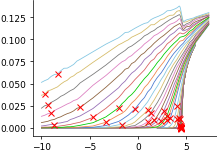

In [86]:
# max_diff_f = np.nanargmax(d2[:,1:last_idx+1], axis=1)+1
max_diff_f = np.nanargmin(np.subtract.outer(max_diff_f_interp, rs)**2, axis=1)
# # For discontinuity in saddle-node, do it by eye
# max_diff_f[max_diff_f > 72] = 72

# # For Supercritical Hopf, fix by maximum frequency 
# for i in range(len(max_diff_f)):
#     if f_sim[i, max_diff_f[i]] > 0.015:
#         j = np.argwhere(f_sim[i, :]> 0.015).ravel()[0]
#         max_diff_f[i] = j

# For discontinuity in subcritical Hopf, do it by eye
# max_diff_f = np.ones(f_sim.shape[0],dtype=int)*np.argwhere(rs > 42.5).ravel()[0]

# for i in range(f_sim.shape[0]):
#     if f_interp[i,max_diff_f[i]] == 0:
#         max_diff_f[i] = np.argwhere(rs > 42.5).ravel()[0]

print(max_diff_f)


# plt.xlim(-0.5, 0.5)
# plt.ylim(-0.01, 0.75)

[200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200 200
 200 200 203 203 203 203 203 203 203 203 203 203 203 203 203 203 203 203
 167 167 167 167]
0.09362901668235468
0.09362976952805435
0.09362960143064702
0.0936216773011452
0.09362371538813338
0.09362351657279405
0.09362420480273288
0.09362420480273288
0.09363653946530316
0.09363628276387187
0.0936218828895287
0.09364561129451719
0.09365082147373957
0.09364635503074245
0.09369019214132139
0.09366532198165436
0.09378306721903104
0.09389232812396857
0.09425755136362864
0.09468985465317199
0.11645033694176853
0.1171836670896874
0.1171192300828791
0.11793354835911136
0.11820688806827603
0.11906268853410673
0.12002960542414864
0.12078813279746348
0.12241108762449289
0.12358467436920975
0.12442837985080199
0.1246792492492805
0.12466148209992624
0.12703998080803114
0.1267029547490295
0.1256456912225765
0.11448460806715659
0.11627193596775087
0.11958183048924385
0.12098358668414294


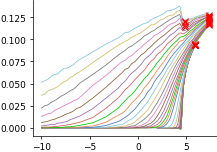

In [87]:
min_diff_f_interp = list(map(lambda x, y: x[np.nanargmin(np.ma.array(y,\
                                            mask=x<det_bifurcation_points[bif]))], eq_sp_rs, d2))

diffs = np.subtract.outer(min_diff_f_interp, rs)**2
diffs[np.isnan(f_interp)] = np.nan
min_diff_f = np.nanargmin(diffs, axis=1)

#For discontinuity in subcritical Hopf, do it by eye
# min_diff_f = np.ones(f_sim.shape[0],dtype=int)*np.argwhere(rs > 47).ravel()[0]

#For discontinuity in subcritical Hopf, do it by eye
# min_diff_f = np.ones(f_sim.shape[0],dtype=int)*np.argwhere(rs > 47).ravel()[0]


print(min_diff_f)
plt.plot(rs, f_interp.T)
for i in range(f_sim.shape[0]):
    print(f_interp[i,min_diff_f[i]])
    plt.plot(rs[min_diff_f[i]], f_interp[i,min_diff_f[i]], "rx")

In [57]:
rs_cutoff = -0.5
start_point = np.ones(cov_sim.shape[0], dtype=int)*rs_cutoff

In [14]:
n_valid = np.sum(~np.isnan(aligned_frequencies), axis=1)
# characteristic_scale = 0.8/(np.mean(n_valid))

In [90]:
characteristic_scale_bif = {"snic":1/np.mean(n_valid), "saddle_node":1/np.mean(n_valid), \
                            "supercritical_hopf": 3/np.mean(n_valid), "subcritical_hopf": 5/np.mean(n_valid)}
scale_factors_bif = {"snic": [500,15,10], "saddle_node": [500,1/0.45,10],\
                     "supercritical_hopf": [100,1/0.15,1], "subcritical_hopf": [100,1/0.18,0.5]}

In [91]:
x_offset_post = 0
n_embryos = aligned_frequencies.shape[0]
#including nans
scale_factors = scale_factors_bif[bif]
xvals_data = np.arange(aligned_frequencies.shape[1])
err_nm = np.zeros((n_embryos, len(sigmas)))
beta_nm = np.zeros((n_embryos, len(sigmas), 3))
flookup_nm = np.zeros(len(sigmas), dtype=object)
covlookup_nm = np.zeros(len(sigmas), dtype=object)
bounds = np.nan*np.ones((n_embryos, len(sigmas), 3, 2))

In [113]:
reload_libraries()

In [ ]:
"""
Equation of scaling
f_expt*c/sf[1] = f_sim((t_expt-t_offset_pre)/sf[0]*a + b/sf[2])
"""
print("Total fits: ", len(sigmas)*n_embryos)
print("N sigma: ", len(sigmas))
n_repeats = 5
rows = np.arange(len(sigmas))
n_embryos = aligned_frequencies.shape[0]
tic = time.time()
for row in rows:
    print("Sigma: ", sigmas[row])
    fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
                                                       540, 0,\
                                                       scale_factors, relweight=1,critical_point=None)
    flookup_nm[row] = f_lookup
    covlookup_nm[row] = cov_lookup

    characteristic_scale = ((rs[min_diff_f[row]] - rs[max_diff_f[row]]))\
                            /np.mean(n_valid)
    print(characteristic_scale*np.mean(n_valid))

    for embryo in range(n_embryos):
#     for embryo in range(aligned_frequencies.shape[0]):
        f_expt = aligned_frequencies[embryo,:]
        cov_expt = aligned_covs[embryo,:]
        bounds_embryo = np.array([[characteristic_scale*scale_factors[0], characteristic_scale*2*scale_factors[0]], \
          [0.75, 2], \
          [(rs[max_diff_f[row]]-characteristic_scale*np.mean(n_valid)/2)*scale_factors[2],\
           (rs[max_diff_f[row]]+characteristic_scale*np.mean(n_valid)/2)*scale_factors[2]]])
#         print(bounds_embryo)
        bounds[embryo,row,:,:] = bounds_embryo

        curr_min_err = np.inf
        curr_params = None
#         for i in range(3):
        for alpha in np.linspace(0.05, 0.95, n_repeats):
            params = lmfit.Parameters()
            params.add('x_scale', value=characteristic_scale*scale_factors[0],\
                       min=bounds_embryo[0,0], max=bounds_embryo[0,1])
            params.add('amplitude', value=(bounds_embryo[1,0]+bounds_embryo[1,1])/2, min=bounds_embryo[1,0], max=bounds_embryo[1,1])
            params.add('x_offset', value=bounds_embryo[2,0]+(bounds_embryo[2,1]-bounds_embryo[2,0])*alpha,\
                       min=bounds_embryo[2,0], max=bounds_embryo[2,1])
            out = lmfit.minimize(fitfun, params, args=(xvals_data, f_expt, cov_expt),\
                                     max_nfev=3000, method="ampgo", tabulistsize=10, eps1=0.08)
            err = np.nanmean(fitfun(out.params, x = xvals_data, dat1=f_expt, dat2=cov_expt)**2)
            if err < curr_min_err:
                curr_params = out.params
                curr_min_err = err
#                 print(i, curr_min_err)
        err_nm[embryo, row] = curr_min_err
        beta_nm[embryo, row, :] = [curr_params['x_scale'].value, curr_params['amplitude'].value, curr_params['x_offset'].value]
#         np.savez(os.path.join(figdir, "Data", "%s_individual_fits.npz" % bif), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)
        if (row*n_embryos+embryo)%100 == 0:
            print("Fit %d complete" % (row*n_embryos+embryo))
    print("Mean err:", np.mean(err_nm[:,row]))
    print((time.time()-tic)/60)
# np.savez(os.path.join("../all_widefield_data/individual_fits.npz"), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)
np.savez(os.path.join(figdir, "Data", "%s_individual_fits_randinit.npz" % bif), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)

In [60]:
reload_libraries()

In [82]:
rows = np.arange(len(sigmas))
n_embryos = aligned_frequencies.shape[0]
max_freq = np.nanmax(aligned_frequencies)
print(max_freq)

tic = time.time()
bif = "snic"
scale_factors = scale_factors_bif[bif]
curr_embryo = 18
curr_row = 17

bif_data = all_data.loc[bif]
f = pd.pivot_table(bif_data, values="freq", index="sigma", columns=["I"], dropna=False)
covs = pd.pivot_table(bif_data, values="isi_cv", index="sigma", columns=["I"], dropna=False)
sigmas = f.index.to_numpy()
rs = f.columns.to_numpy()
f_sim = f.to_numpy()
cov_sim = covs.to_numpy()
x_offset_post = 0

for row in [curr_row]:
    print("Sigma: ", sigmas[row])
    fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
                                                       540, 0,\
                                                       scale_factors, relweight=1,critical_point=None)
    flookup_nm[row] = f_lookup
    covlookup_nm[row] = cov_lookup

    characteristic_scale = ((rs[min_diffs[bif][row]] - rs[max_diffs[bif][row]]))\
                            /np.mean(n_valid)
    print(characteristic_scale*np.mean(n_valid))


    for embryo in [curr_embryo]:
#     for embryo in range(aligned_frequencies.shape[0]):
        f_expt = aligned_frequencies[embryo,:]
        cov_expt = aligned_covs[embryo,:]
        bounds_embryo = np.array([[characteristic_scale*0.75*scale_factors[0], characteristic_scale*2*scale_factors[0]], \
          [0.75, 2], \
        [((rs[np.argwhere(cov_sim[row]>0).ravel()[0]]-characteristic_scale*np.mean(n_valid)/2*0.1)*scale_factors[2]),\
           (rs[max_diff_f[row]]+characteristic_scale*np.mean(n_valid)/2)*scale_factors[2]]])
#             print(np.argwhere(cov_expt > 0))
#             print(bounds_embryo[2]/scale_factors[2])
#             print(rs[np.argwhere(cov_sim[row]>0).ravel()[0]])
#         bounds[embryo,row,:,:] = bounds_embryo
#             print(bounds_embryo)

        curr_min_err = np.inf
        curr_params = None
#         for i in range(3):
        for alpha in np.linspace(0.05, 0.95, n_repeats):
            params = lmfit.Parameters()
            params.add('x_scale', value=characteristic_scale*scale_factors[0],\
                       min=bounds_embryo[0,0], max=bounds_embryo[0,1])
            params.add('amplitude', value=(bounds_embryo[1,0]+bounds_embryo[1,1])/2, min=bounds_embryo[1,0], max=bounds_embryo[1,1])
            params.add('x_offset', value=bounds_embryo[2,0]+(bounds_embryo[2,1]-bounds_embryo[2,0])*alpha,\
                       min=bounds_embryo[2,0], max=bounds_embryo[2,1])
            try:
                out = lmfit.minimize(fitfun, params, args=(xvals_data, f_expt, cov_expt),\
                                     max_nfev=10000, method="ampgo", tabulistsize=10, eps1=0.08)
                err = np.nanmean(fitfun(out.params, x = xvals_data, dat1=f_expt, dat2=cov_expt)**2)
                if err < curr_min_err:
                    curr_params = out.params
                    curr_min_err = err
                    curr_fitfun = copy.deepcopy(fitfun)
            except Exception as e:
                print("Max fev exceeded")
                pass
#                 print(i, curr_min_err)
#         err_nm[embryo, row] = curr_min_err
        curr_params = [curr_params['x_scale'].value, curr_params['amplitude'].value, curr_params['x_offset'].value]
#         np.savez(os.path.join(figdir, "Data", "%s_individual_fits.npz" % bif), err_nm=err_nm, beta_nm=beta_nm, bounds=bounds)
        if (row*n_embryos+embryo)%100 == 0:
            print("Fit %d complete" % (row*n_embryos+embryo))
    print("Mean err:", np.mean(err_nm[:,row]))
    print((time.time()-tic)/60)

0.9997733711048158
Sigma:  16.457795
1.7055559999999998
Mean err: 2.295605249145238e-06
0.04903499285380045


In [69]:
print(bounds_embryo)
print(bounds_embryo[2]/scale_factors[2])
print(curr_params)

[[ 0.76575663  2.04201768]
 [ 0.75        2.        ]
 [35.480552   36.52778   ]]
[3.5480552 3.652778 ]
[2.042017682814514, 1.1035978676808784, 36.527779999999986]


In [54]:
xvals_data

array([   0,    1,    2, ..., 1599, 1600, 1601])

0.0006847555594679033
0.0006847555594679033


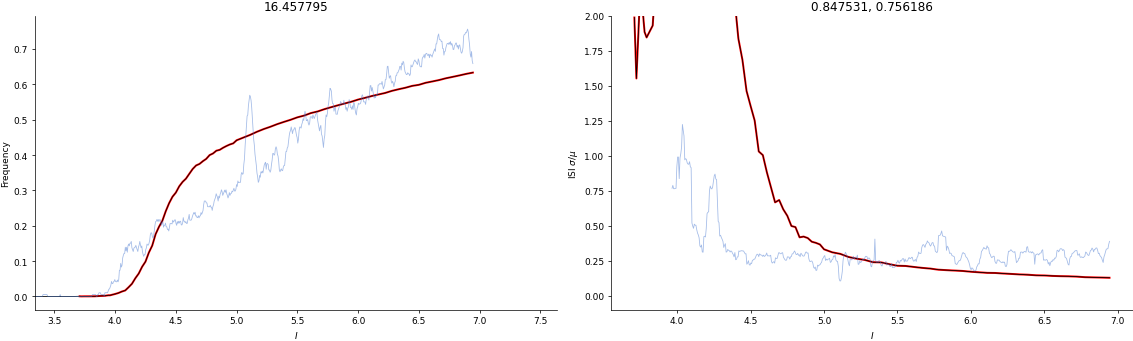

In [81]:
plt.close("all")
# for row in range(f_sim.shape[0]):
#     axes = axes.ravel()
frequency = f_sim[curr_row,:]
cov = cov_sim[curr_row,:]
x_offset_post = 0
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (xvals_data-540)/scale_factors[0]*curr_params[0] +\
                curr_params[2]/scale_factors[2] + x_offset_post
# sf0 = 500
# xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/sf0*beta_nm[:,row,0][:,np.newaxis] +\
#                 beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post

finite_mask = np.isfinite(frequency) & np.isfinite(cov)
print(np.nanmean(fitfun({"x_scale": curr_params[0], "amplitude": curr_params[1], "x_offset": curr_params[2]},\
                  x = xvals_data, dat1=f_expt, dat2=cov_expt)**2))
print(np.nanmean(fitfun({"x_scale": curr_params[0], "amplitude": curr_params[1], "x_offset": curr_params[2]},\
                  x = xvals_data, dat1=f_expt, dat2=cov_expt)**2))

fig1, axes = plt.subplots(1, 2, figsize=(16,5))
axes[0].plot(rs[finite_mask], frequency[finite_mask], color="red", linewidth=2)
axes[1].plot(rs[finite_mask], cov[finite_mask], color="red", linewidth=2)
axes[0].plot(rs, frequency, color="black")
axes[1].plot(rs, cov, color="black")
f_expt = aligned_frequencies[curr_embryo,:]
axes[1].set_title("%f, %f" % (np.nanmax(f_expt), np.nanmax(f_expt*curr_params[1]/scale_factors[1])))
cov_expt = aligned_covs[curr_embryo,:]
axes[0].plot(xvals_data_scaled, f_expt*curr_params[1]/scale_factors[1], alpha=0.5, label="E%d" % curr_embryo)
axes[1].plot(xvals_data_scaled, cov_expt, alpha=0.5)
#     axes[0].legend()
axes[0].set_xlabel(r"$I$")
axes[1].set_xlabel(r"$I$")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel(r"ISI $\sigma/\mu$")
xmax = 0.8
axes[0].set_xlim((np.min(rs[finite_mask])*0.9, np.max(rs[finite_mask])*1.1))
axes[0].set_title(sigmas[row])
# axes[1].set_xlim((-0.5,xmax))
# axes[0].set_ylim((-0.1,0.6))

axes[1].set_ylim((-0.1, 2))
plt.tight_layout()

8.952860471666426e-05


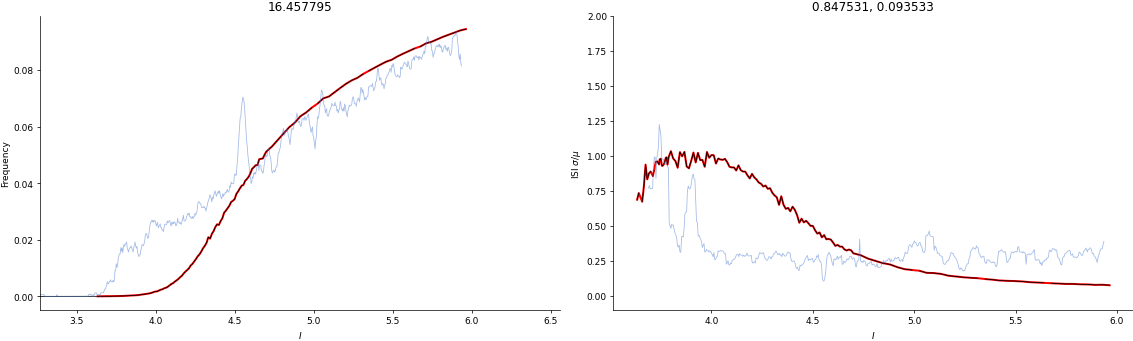

In [83]:
plt.close("all")
# for row in range(f_sim.shape[0]):
#     axes = axes.ravel()
frequency = f_sim[curr_row,:]
cov = cov_sim[curr_row,:]
x_offset_post = 0
xvals_data = np.arange(aligned_frequencies.shape[1])
xvals_data_scaled = (xvals_data-540)/scale_factors[0]*curr_params[0] +\
                curr_params[2]/scale_factors[2] + x_offset_post
# sf0 = 500
# xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/sf0*beta_nm[:,row,0][:,np.newaxis] +\
#                 beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post

finite_mask = np.isfinite(frequency) & np.isfinite(cov)
print(np.nanmean(fitfun({"x_scale": curr_params[0], "amplitude": curr_params[1], "x_offset": curr_params[2]},\
                  x = xvals_data, dat1=f_expt, dat2=cov_expt)**2))

fig1, axes = plt.subplots(1, 2, figsize=(16,5))
axes[0].plot(rs[finite_mask], frequency[finite_mask], color="red", linewidth=2)
axes[1].plot(rs[finite_mask], cov[finite_mask], color="red", linewidth=2)
axes[0].plot(rs, frequency, color="black")
axes[1].plot(rs, cov, color="black")
f_expt = aligned_frequencies[curr_embryo,:]
axes[1].set_title("%f, %f" % (np.nanmax(f_expt), np.nanmax(f_expt*curr_params[1]/scale_factors[1])))
cov_expt = aligned_covs[curr_embryo,:]
axes[0].plot(xvals_data_scaled, f_expt*curr_params[1]/scale_factors[1], alpha=0.5, label="E%d" % curr_embryo)
axes[1].plot(xvals_data_scaled, cov_expt, alpha=0.5)
#     axes[0].legend()
axes[0].set_xlabel(r"$I$")
axes[1].set_xlabel(r"$I$")
axes[0].set_ylabel("Frequency")
axes[1].set_ylabel(r"ISI $\sigma/\mu$")
xmax = 0.8
axes[0].set_xlim((np.min(rs[finite_mask])*0.9, np.max(rs[finite_mask])*1.1))
axes[0].set_title(sigmas[row])
# axes[1].set_xlim((-0.5,xmax))
# axes[0].set_ylim((-0.1,0.6))

axes[1].set_ylim((-0.1, 2))
plt.tight_layout()

In [18]:
scale_factors_bif = {"snic": [500,15,10], "saddle_node": [500,1/0.45,10],\
                     "supercritical_hopf": [100,1/0.15,1], "subcritical_hopf": [100,1/0.18,0.5]}

In [41]:
bif = "snic"
q = np.load(os.path.join(figdir, "Data", "%s_individual_fits_randinit3.npz" % bif))
beta_nm = q["beta_nm"]
bounds = q["bounds"]

bif_data = all_data.loc[bif]
f = pd.pivot_table(bif_data, values="freq", index="sigma", columns=["I"], dropna=False)
covs = pd.pivot_table(bif_data, values="isi_cv", index="sigma", columns=["I"], dropna=False)
sigmas = f.index.to_numpy()
rs = f.columns.to_numpy()
f_sim = f.to_numpy()
cov_sim = covs.to_numpy()
scale_factors = scale_factors_bif[bif]

[ 1.30776074  0.75001004 45.01806506]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 1.2457258   0.75007513 45.08879236]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 1.12012727  0.75034333 48.19077962]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 0.98158038  0.75000014 42.46122949]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 0.86055263  0.75000413 47.95258521]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 0.97028981  0.75002037 47.23850797]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 0.88239099  0.75000723 47.12658536]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.96

/tmp/ipykernel_73843/3355093347.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, axes = plt.subplots(1, 2, figsize=(16,5))


[ 0.86087378  0.75       49.06736003]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 1.25010185  0.75000651 46.56282464]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 0.87864172  0.75000308 47.12703168]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 1.17390463  0.75003754 46.27465391]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 1.15449069  0.75002006 46.33915145]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 1.59893175  0.75000049 42.43436928]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.9694445 ]
[ 1.587248    0.75000596 43.18150149]
[[ 0.86054076  2.29477537]
 [ 0.75        2.        ]
 [33.7083365  49.694445  ]]
[3.37083365 4.96

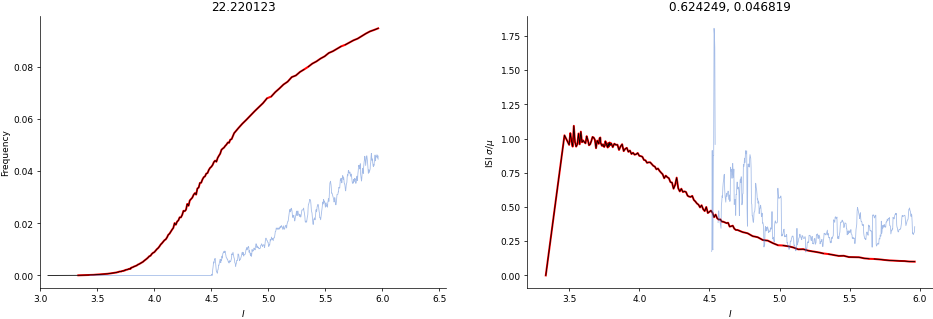

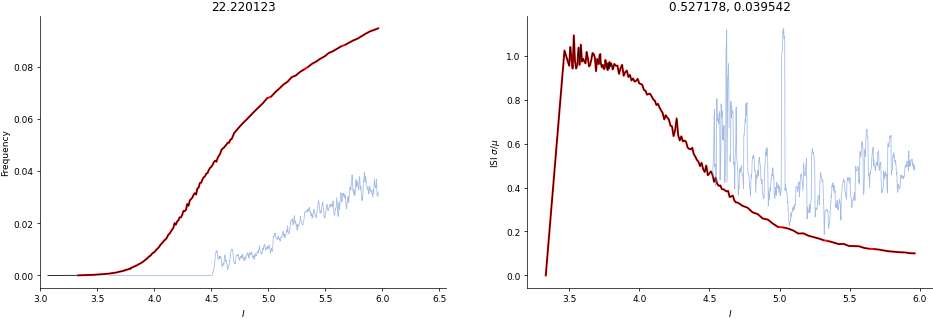

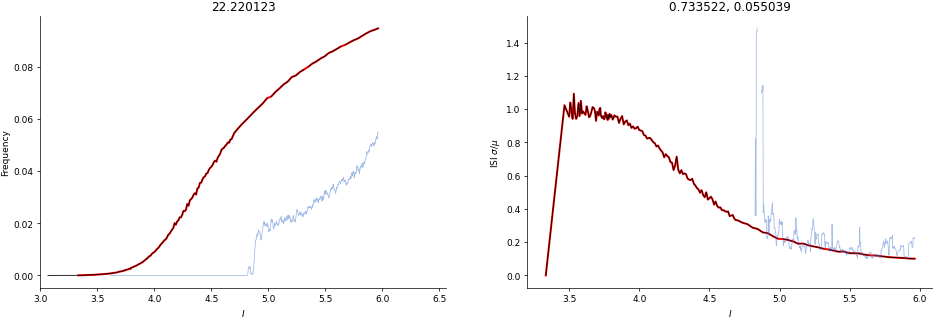

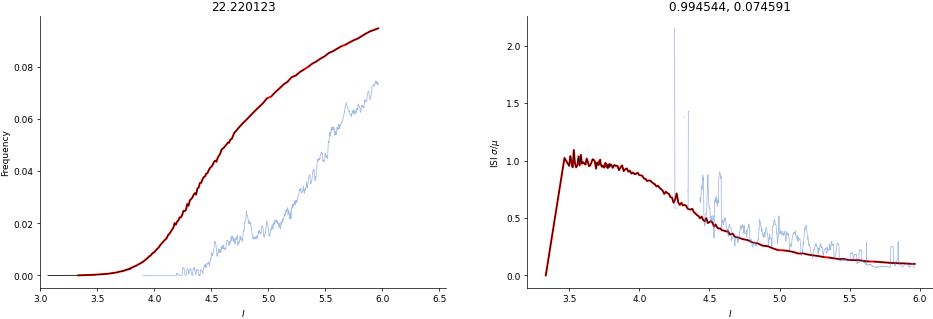

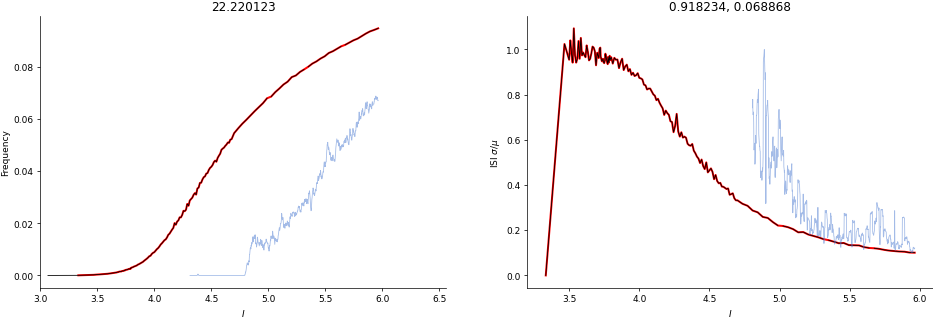

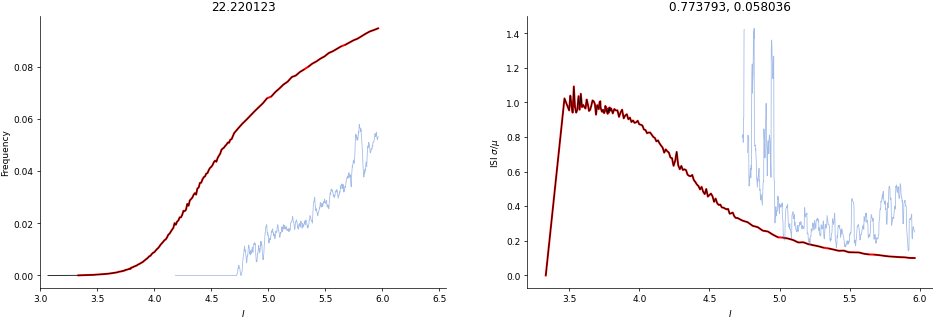

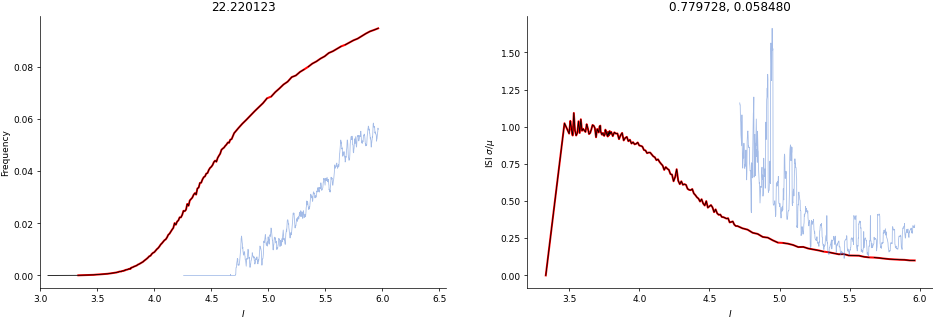

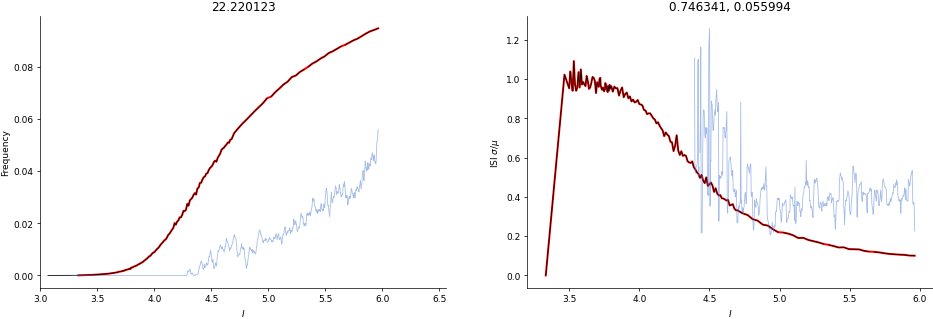

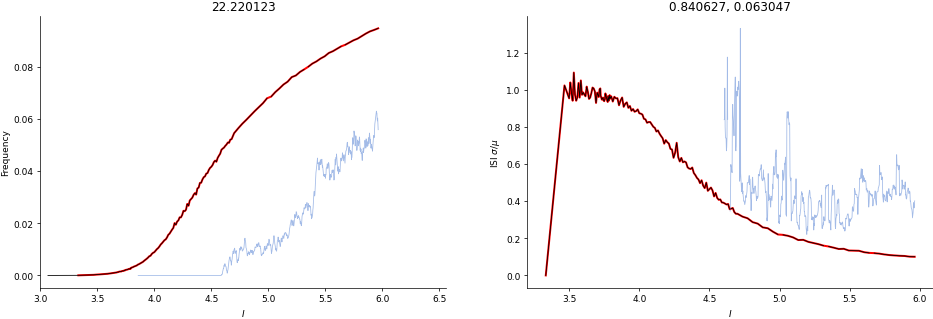

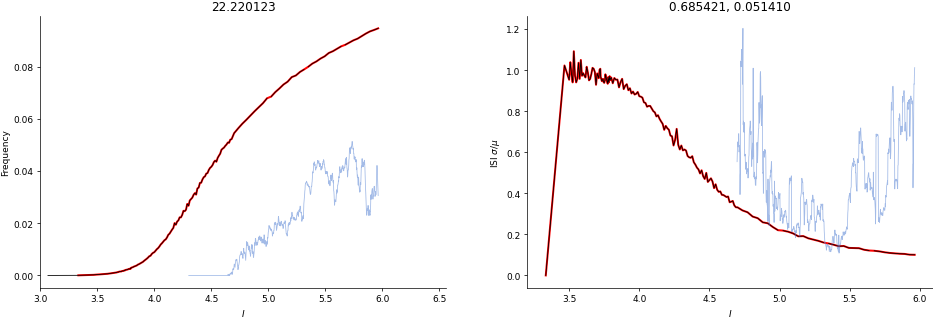

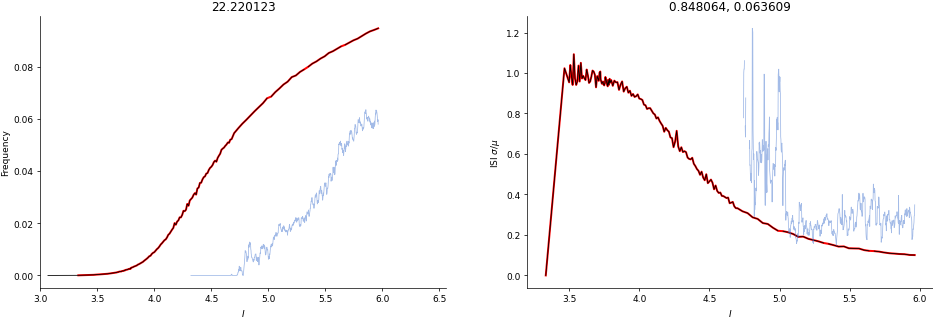

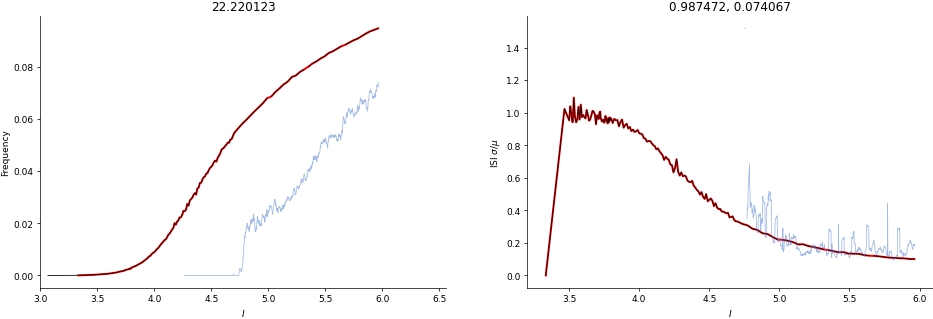

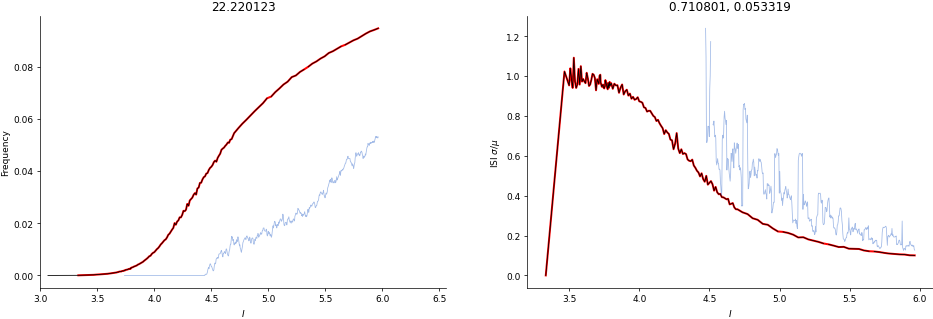

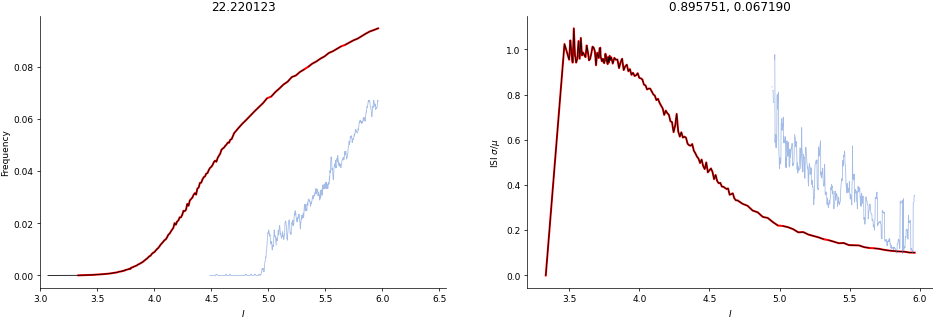

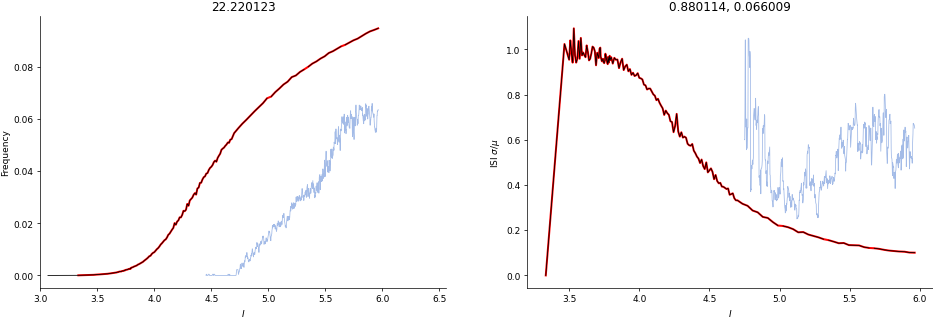

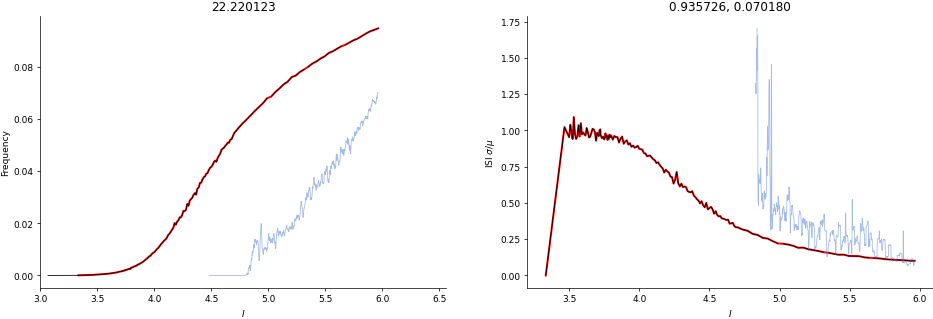

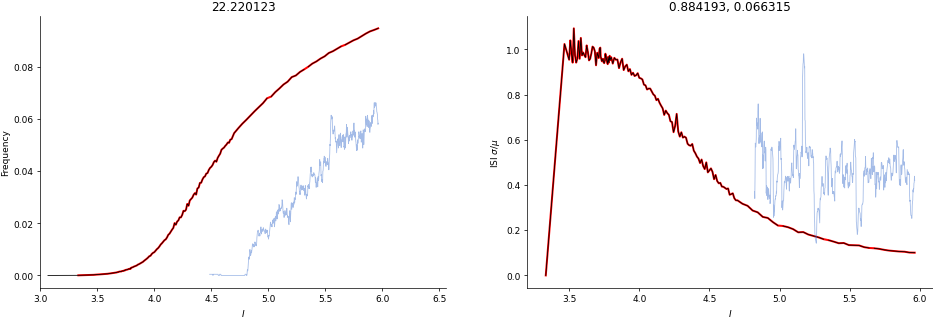

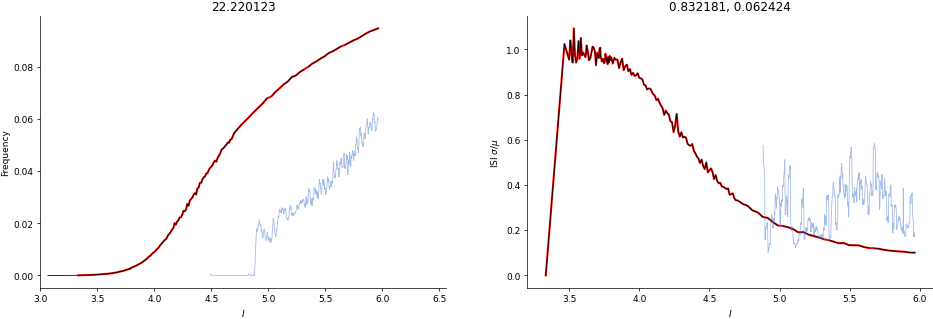

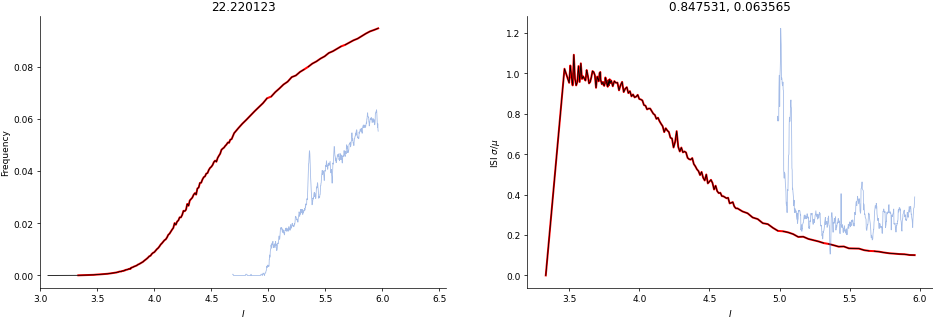

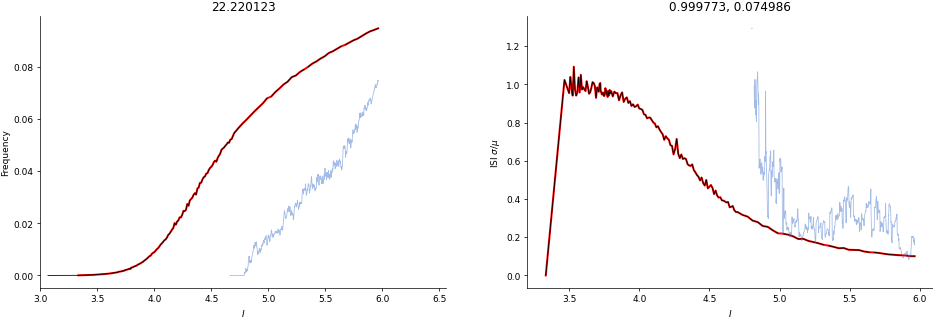

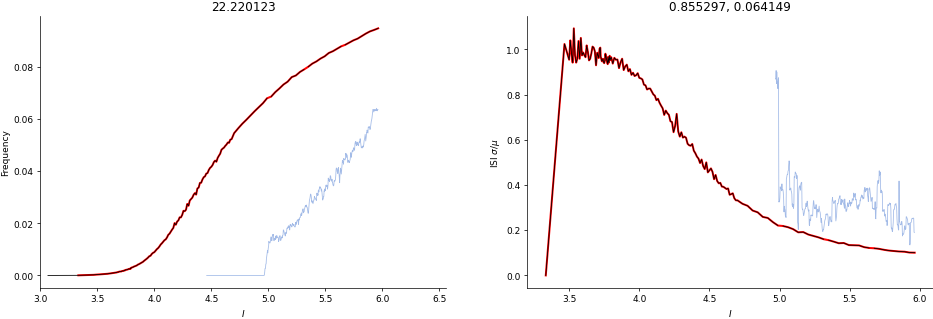

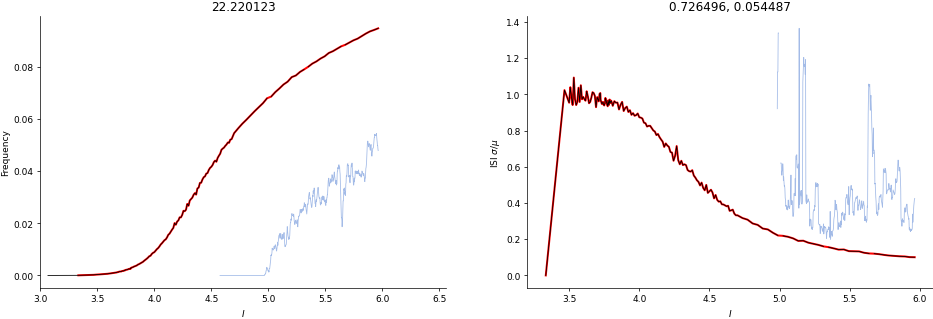

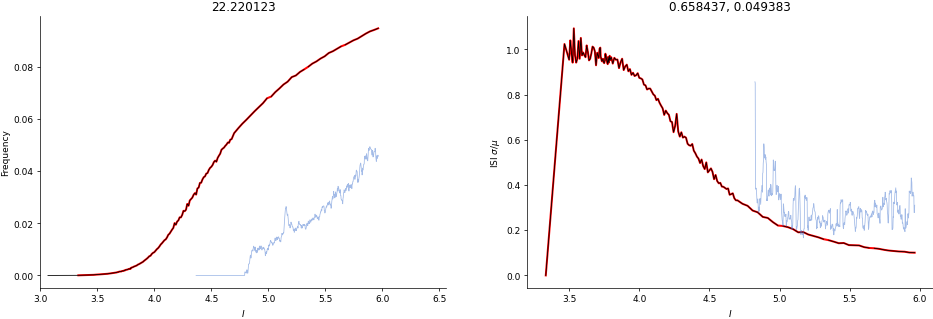

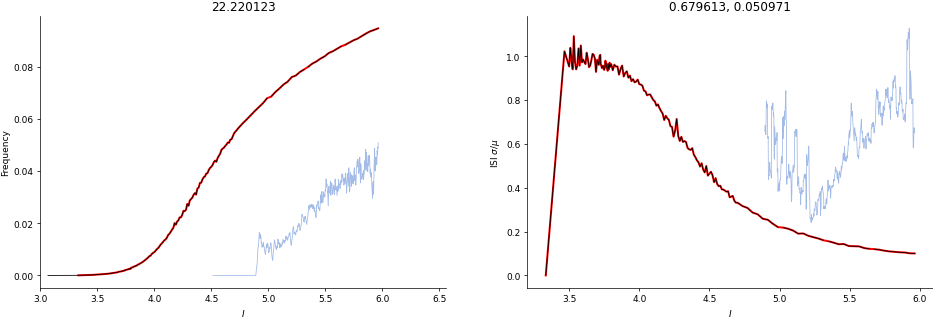

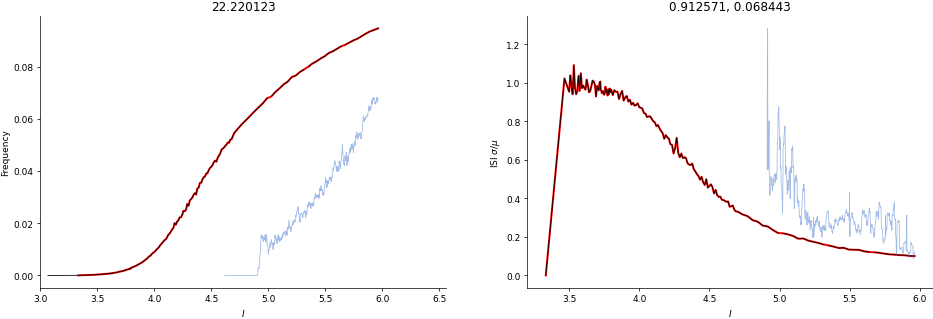

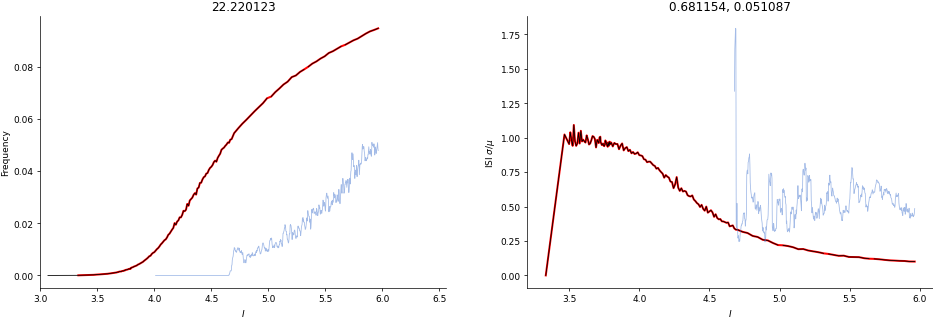

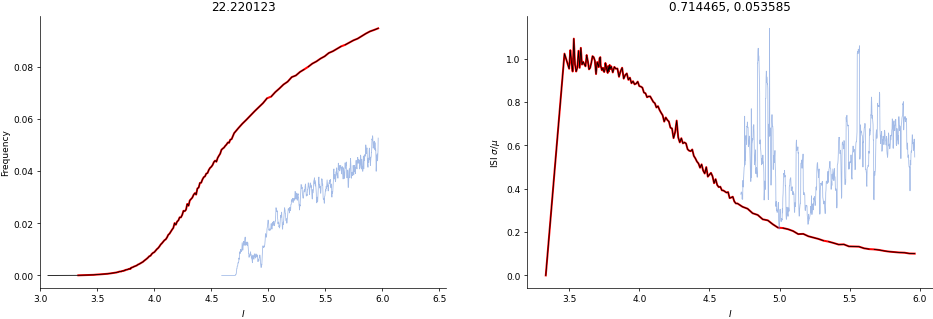

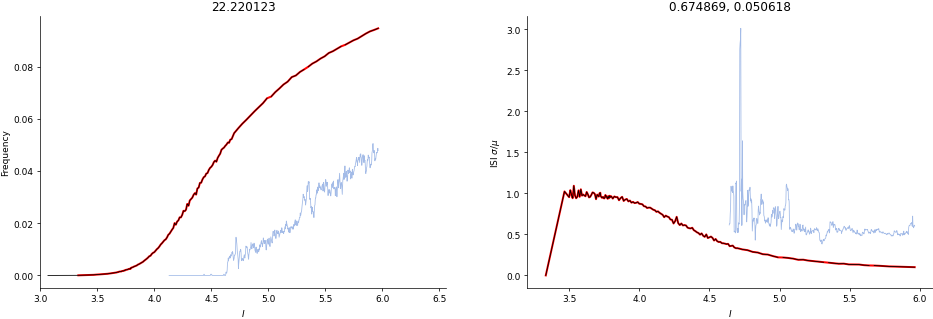

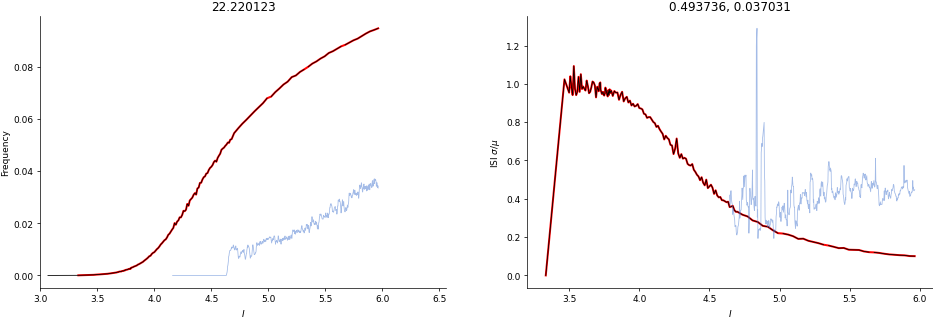

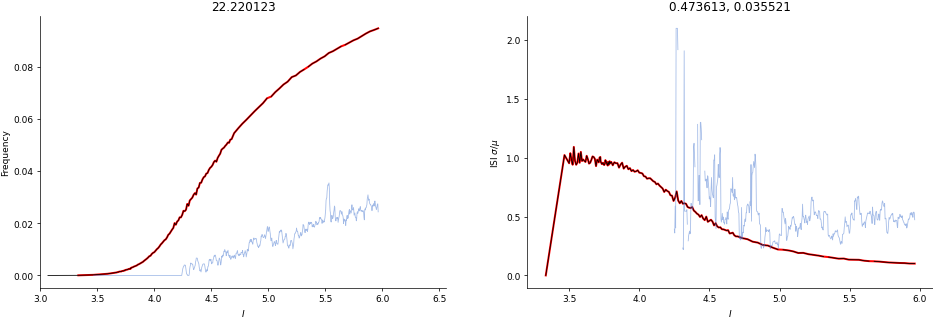

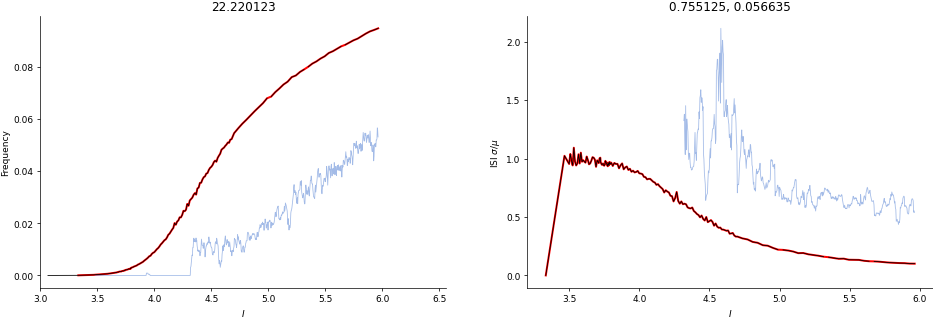

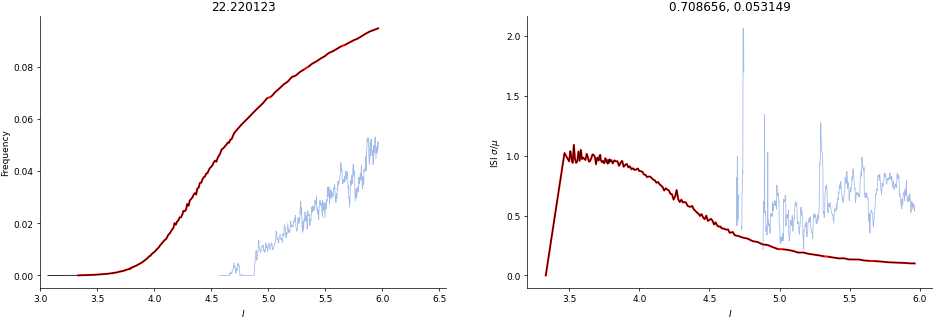

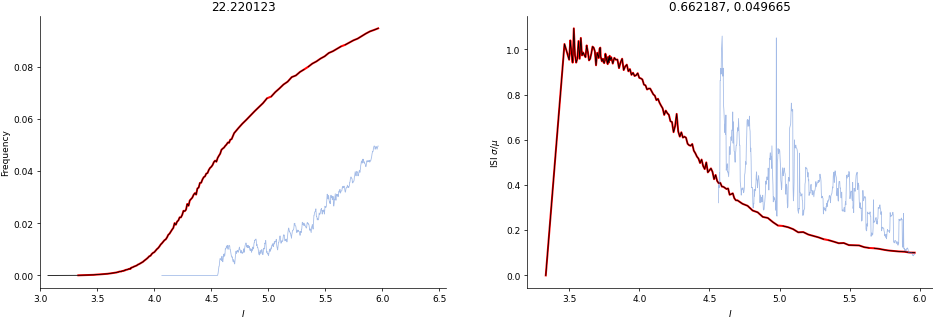

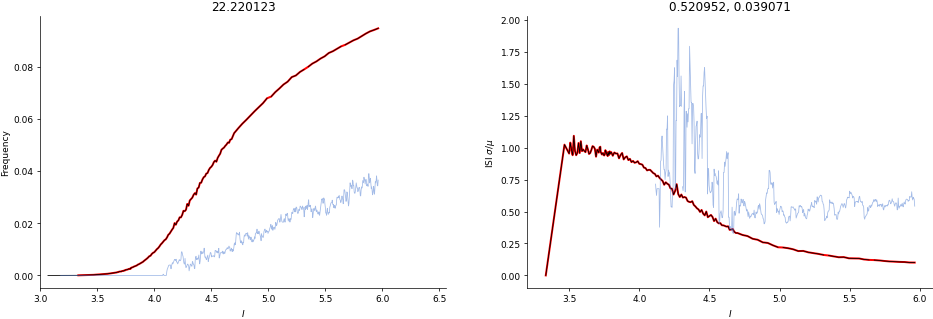

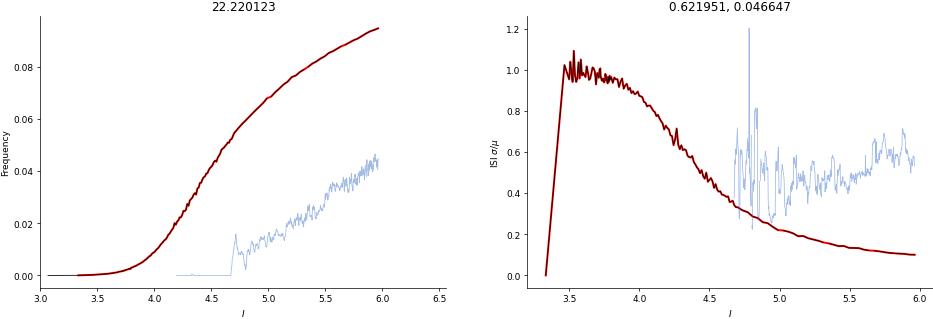

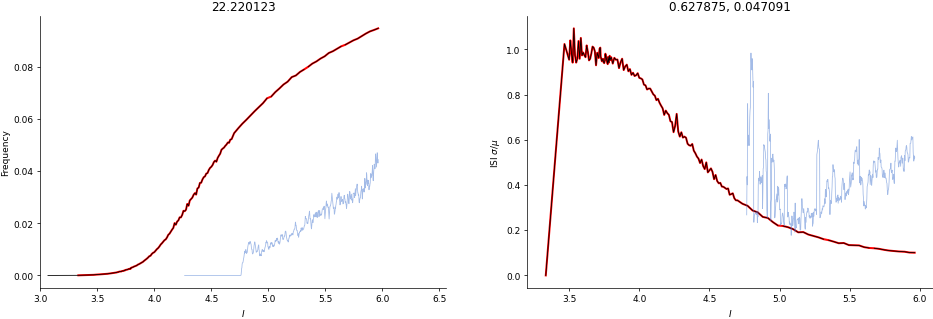

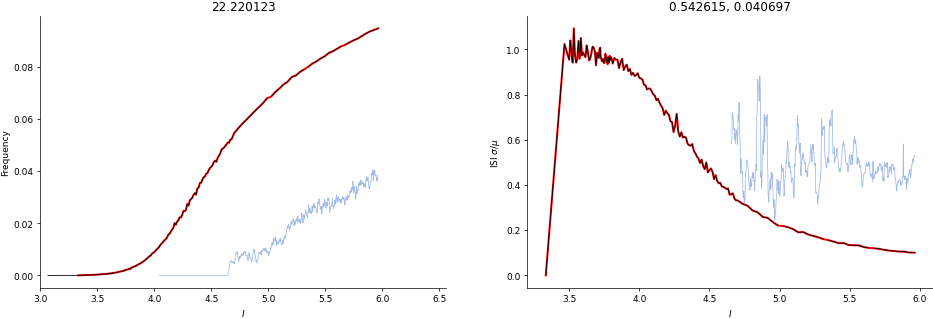

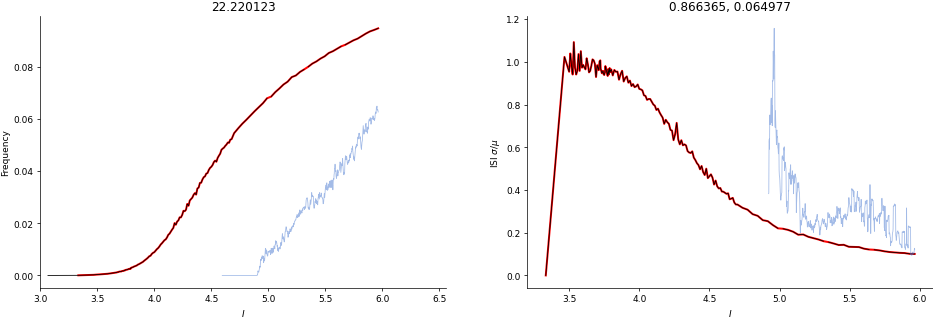

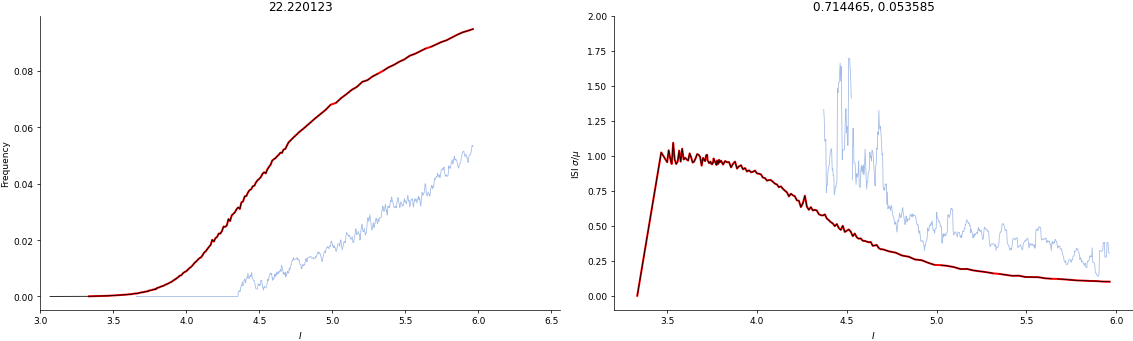

In [42]:
plt.close("all")
# for row in range(f_sim.shape[0]):
for row in [18]:
#     axes = axes.ravel()
    frequency = f_sim[row,:]
    cov = cov_sim[row,:]
    x_offset_post = 0
    xvals_data = np.arange(aligned_frequencies.shape[1])
    xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                    beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post
    # sf0 = 500
    # xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/sf0*beta_nm[:,row,0][:,np.newaxis] +\
    #                 beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post


    dIdt = beta_nm[:,row,0]/scale_factors[0]/dt
    finite_mask = np.isfinite(frequency) & np.isfinite(cov)


    sorted_indices = np.random.choice(20, size=5, replace=False)
    for e in np.arange(aligned_frequencies.shape[0]):
        
        fig1, axes = plt.subplots(1, 2, figsize=(16,5))
        print(beta_nm[e,row,:])
        print(bounds[e,row,:,:])
        print(bounds[e,row,2,:]/scale_factors[2])
        axes[0].plot(rs[finite_mask], frequency[finite_mask], color="red", linewidth=2)
        axes[1].plot(rs[finite_mask], cov[finite_mask], color="red", linewidth=2)
        axes[0].plot(rs, frequency, color="black")
        axes[1].plot(rs, cov, color="black")
        f_expt = aligned_frequencies[e,:]
        axes[1].set_title("%f, %f" % (np.nanmax(f_expt), np.nanmax(f_expt*beta_nm[e,row,1]/scale_factors[1])))
        cov_expt = aligned_covs[e,:]
        axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1]/scale_factors[1], alpha=0.5, label="E%d" % e)
        axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
#     axes[0].legend()
        axes[0].set_xlabel(r"$I$")
        axes[1].set_xlabel(r"$I$")
        axes[0].set_ylabel("Frequency")
        axes[1].set_ylabel(r"ISI $\sigma/\mu$")
        xmax = 0.8
        axes[0].set_xlim((np.min(rs[finite_mask])*0.9, np.max(rs[finite_mask])*1.1))
        axes[0].set_title(sigmas[row])
    # axes[1].set_xlim((-0.5,xmax))
    # axes[0].set_ylim((-0.1,0.6))

    axes[1].set_ylim((-0.1, 2))
    plt.tight_layout()

In [22]:
bif = "subcritical_hopf"
q = np.load(os.path.join(figdir, "Data", "%s_individual_fits_randinit3.npz" % bif))
beta_nm = q["beta_nm"]
bounds = q["bounds"]

bif_data = all_data.loc[bif]
f = pd.pivot_table(bif_data, values="freq", index="sigma", columns=["I"], dropna=False)
covs = pd.pivot_table(bif_data, values="isi_cv", index="sigma", columns=["I"], dropna=False)
sigmas = f.index.to_numpy()
rs = f.columns.to_numpy()
f_sim = f.to_numpy()
cov_sim = covs.to_numpy()
scale_factors = scale_factors_bif[bif]

In [23]:
bounds.shape

(39, 40, 3, 2)

/tmp/ipykernel_131706/3360829503.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig1, axes = plt.subplots(1, 2, figsize=(16,5))


40.0
[35.53333335 40.6666665 ]
44.474989
[32.64166665 36.5833335 ]
49.450616
[30.525 35.75 ]
54.982889
[27.45 33.5 ]
61.134085
[25.275 33.25 ]
67.973443
[19.175 28.25 ]
75.577953
[16.175 25.25 ]


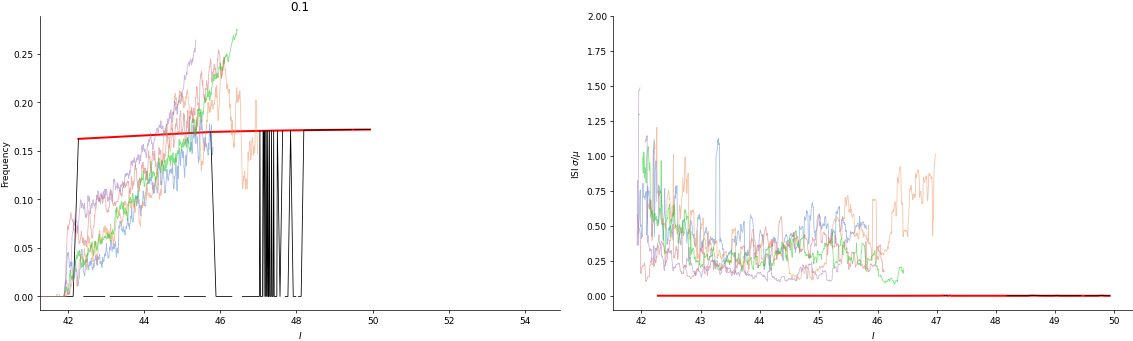

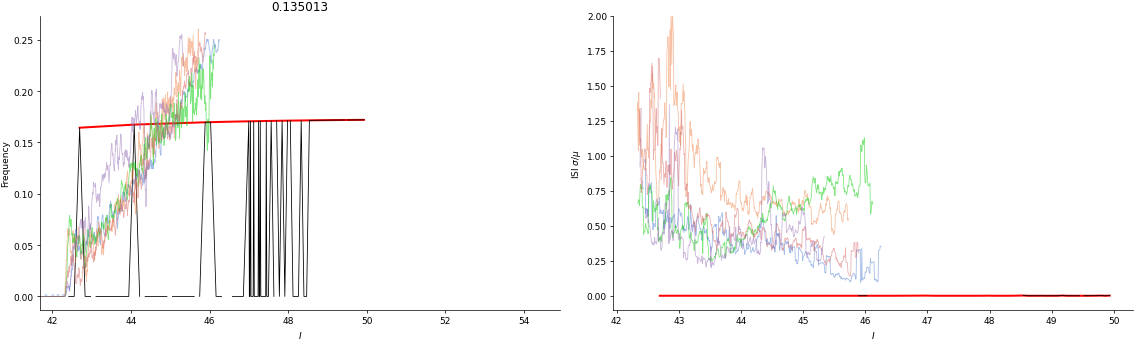

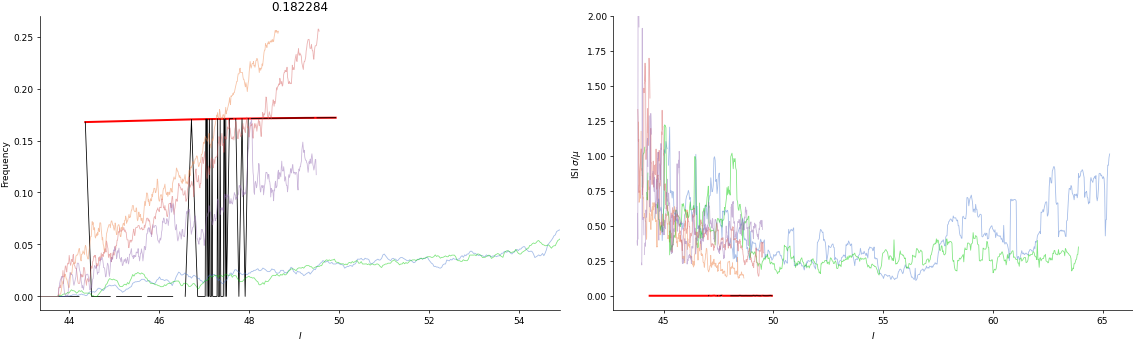

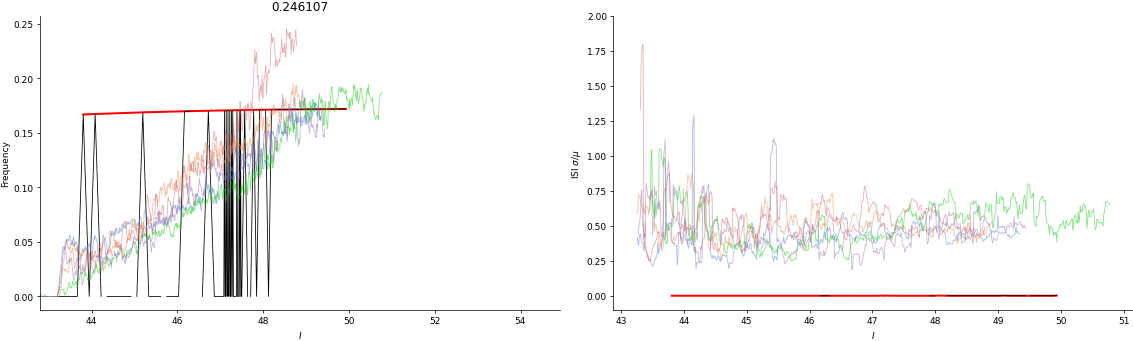

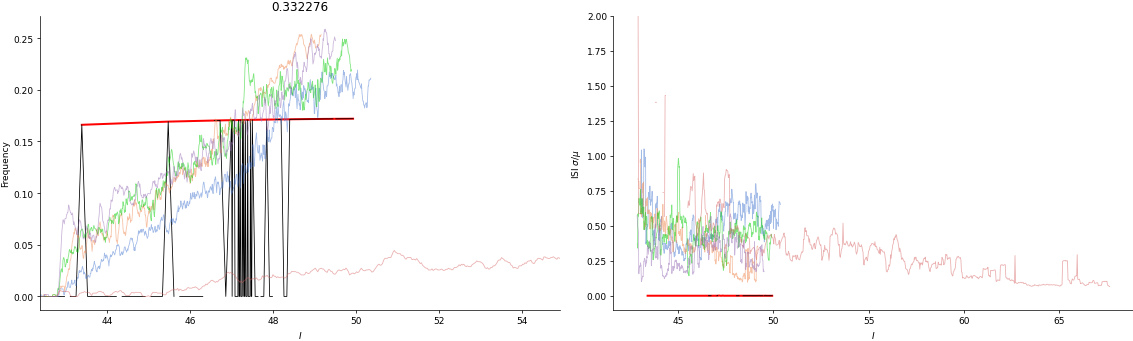

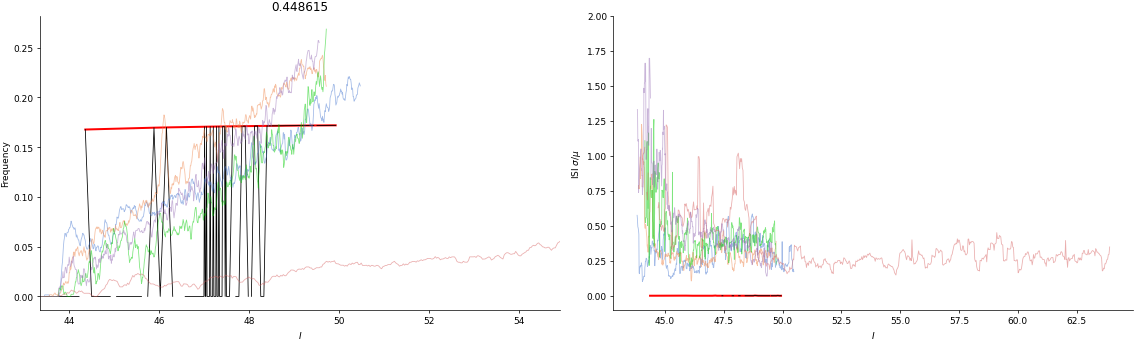

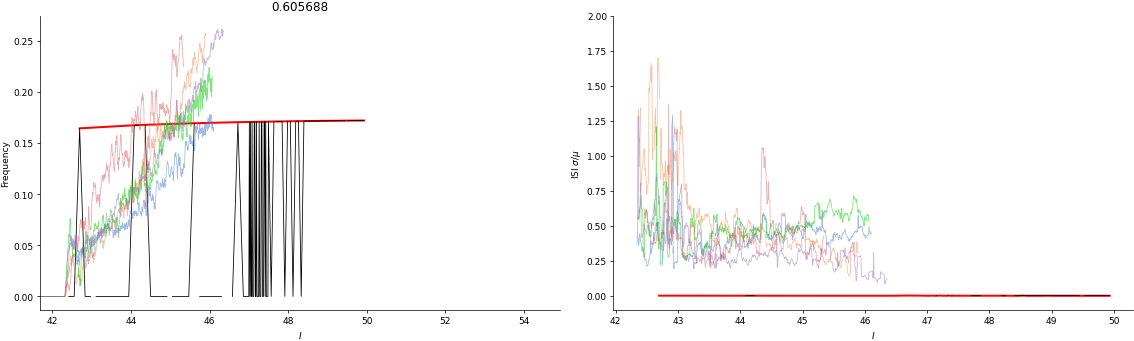

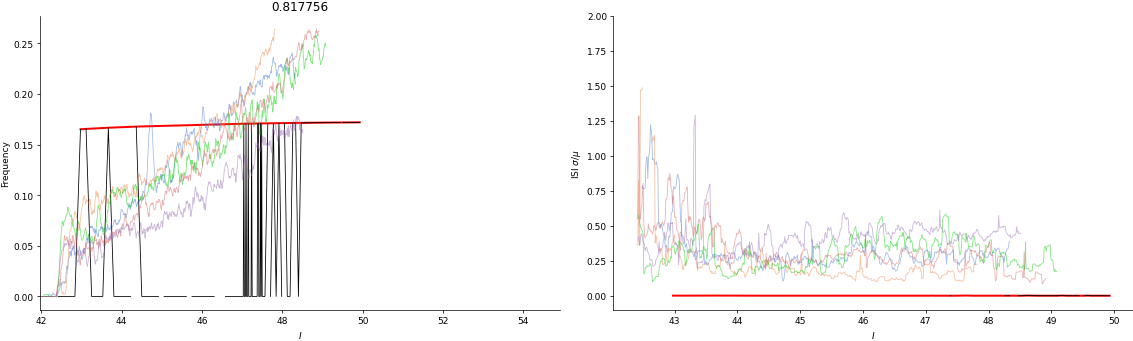

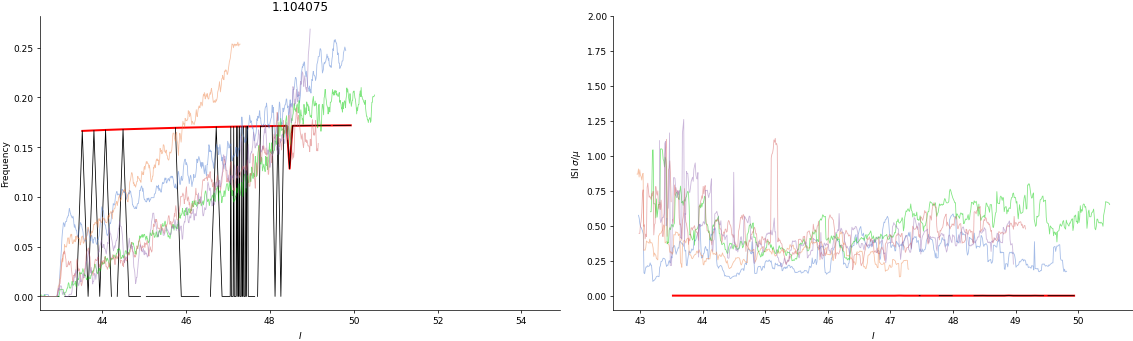

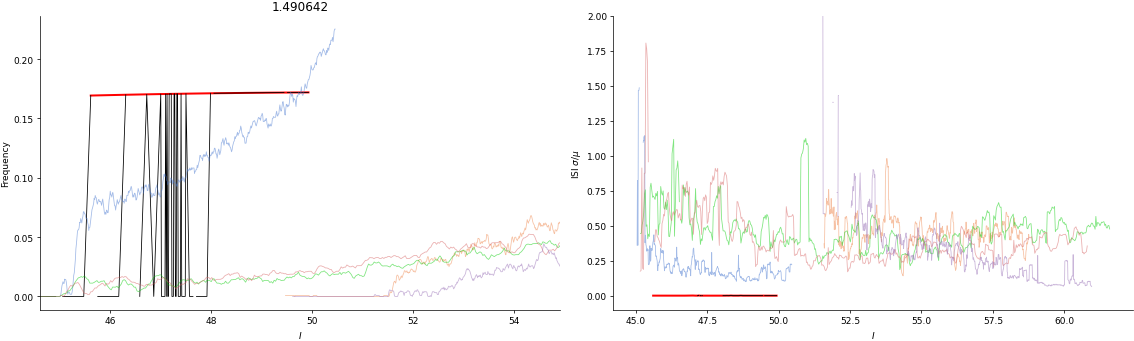

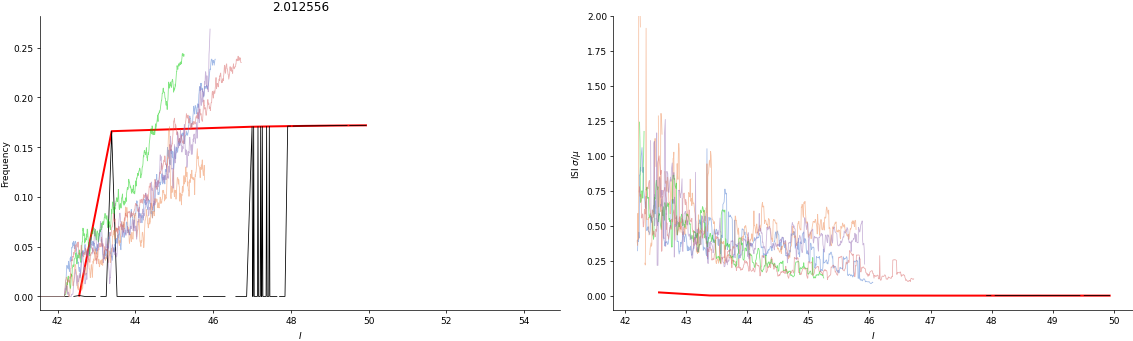

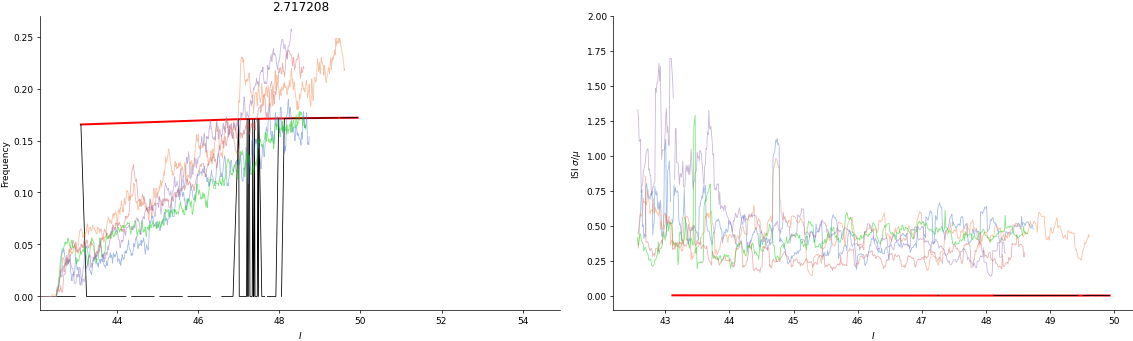

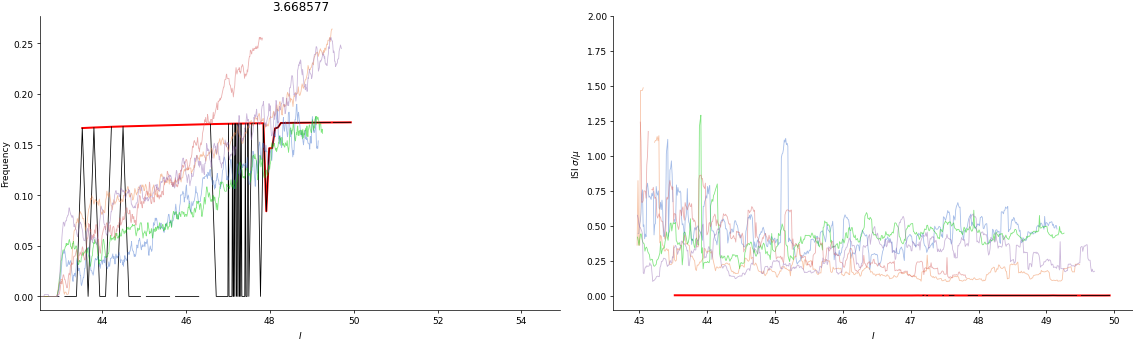

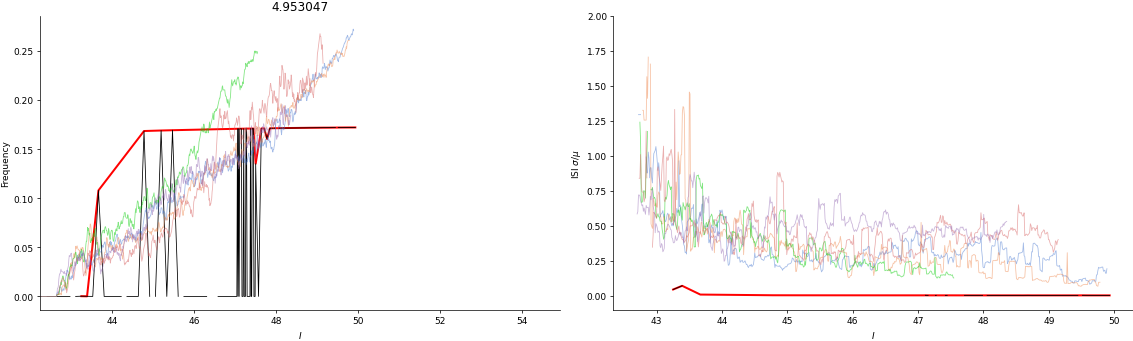

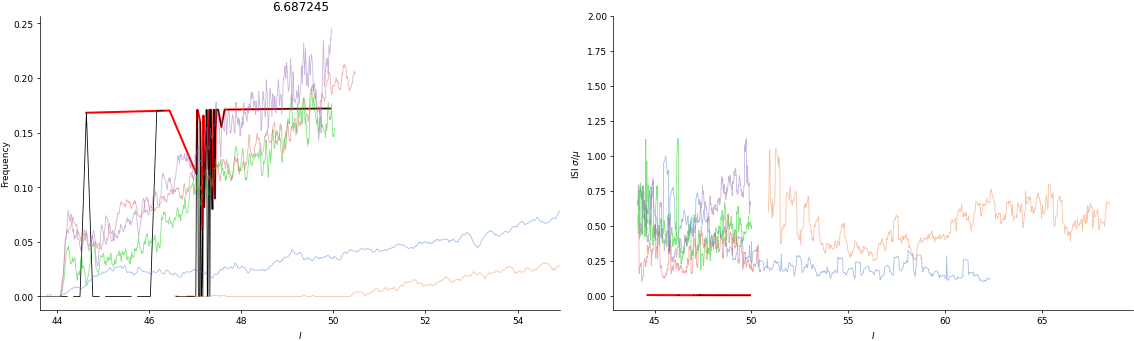

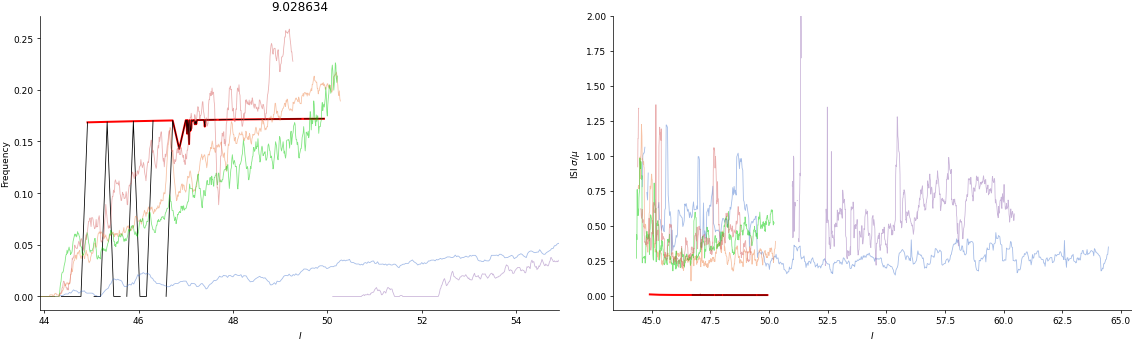

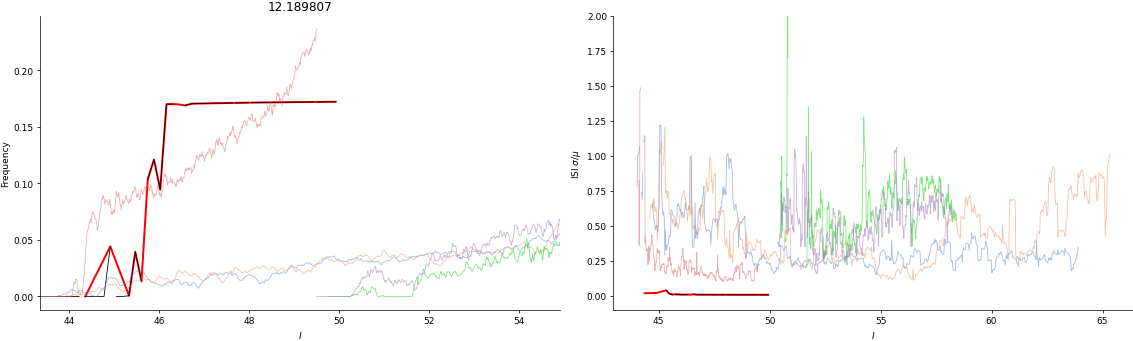

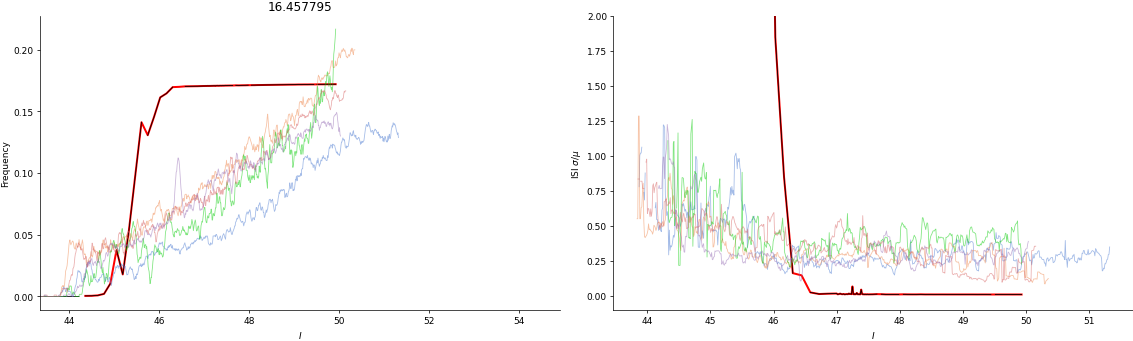

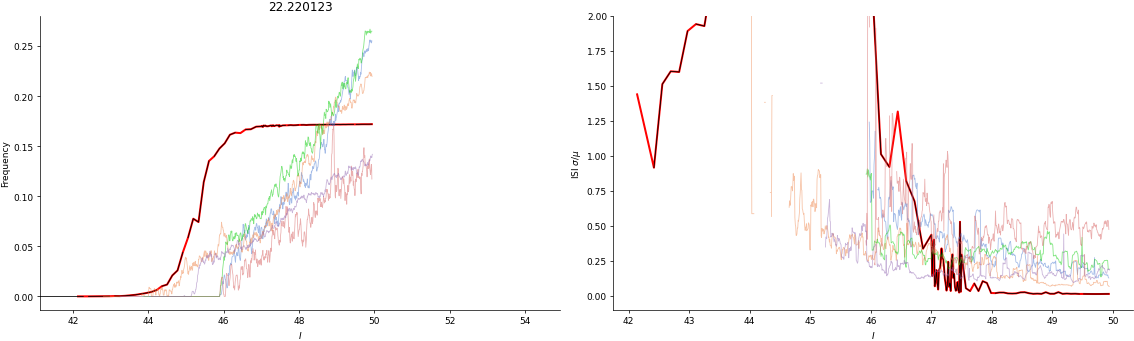

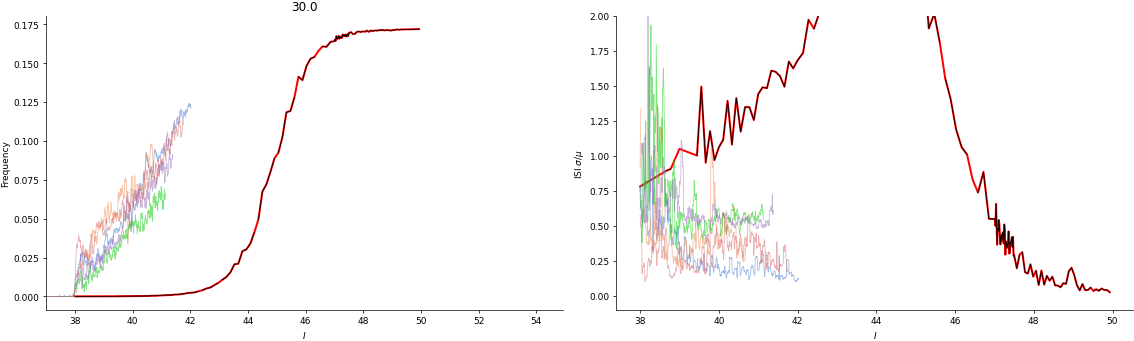

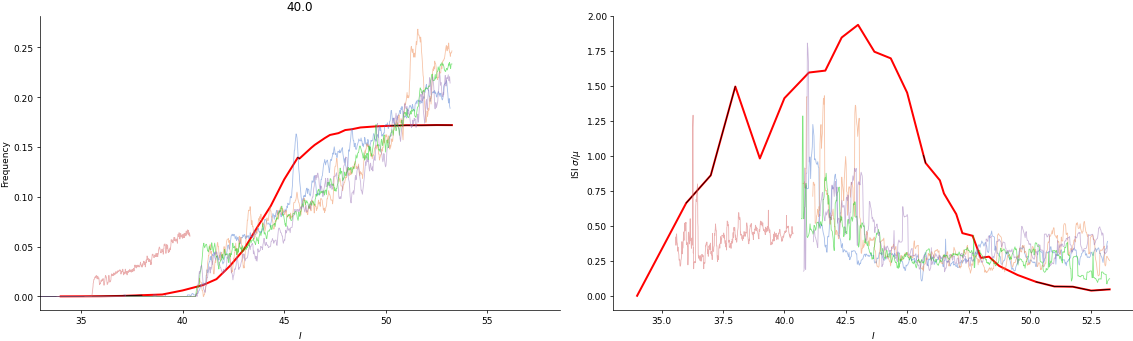

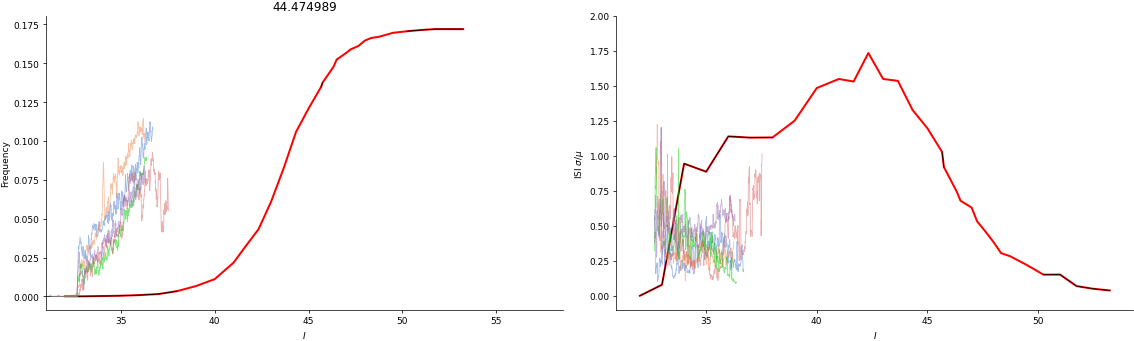

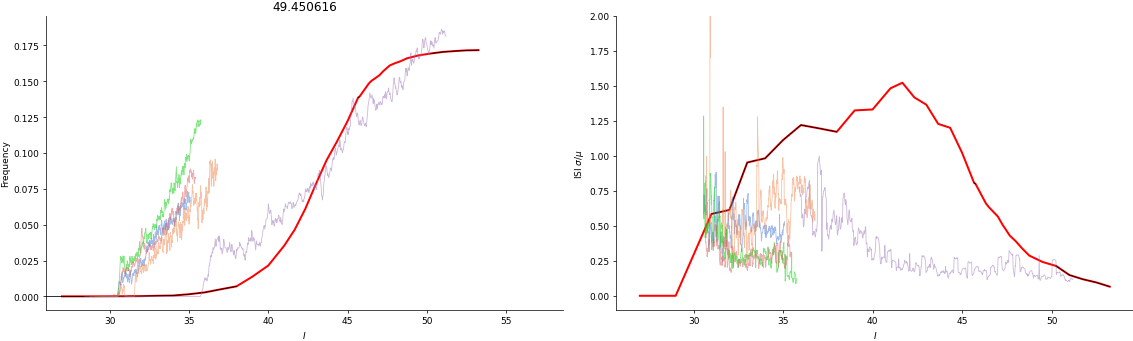

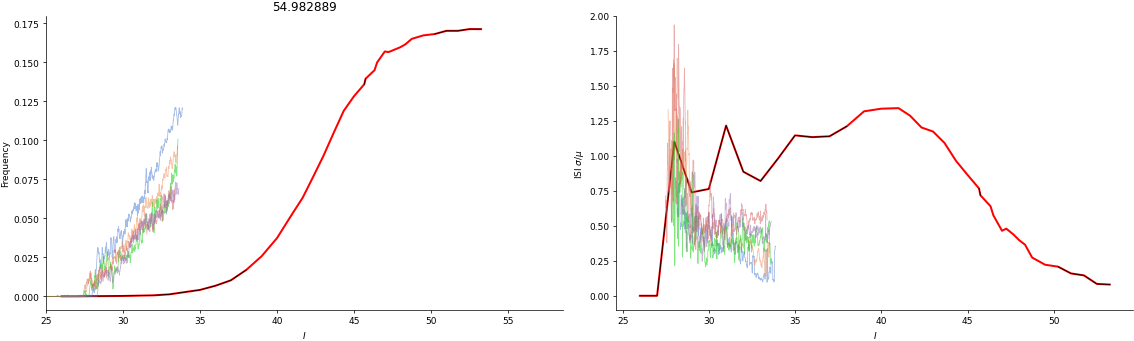

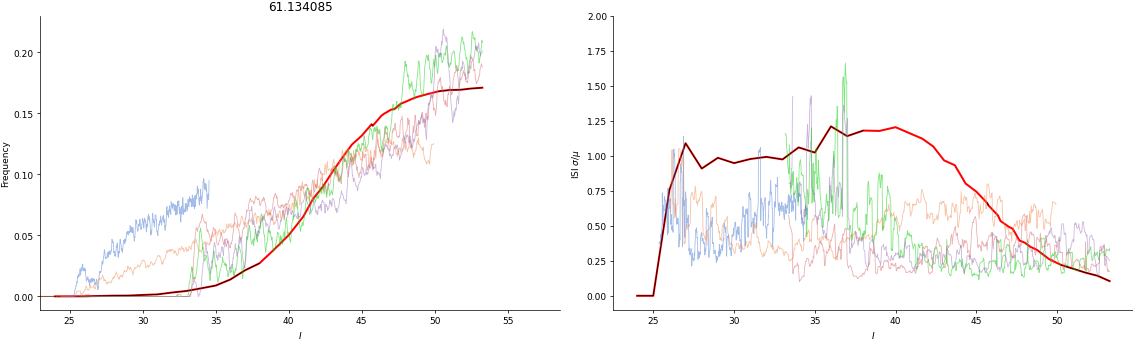

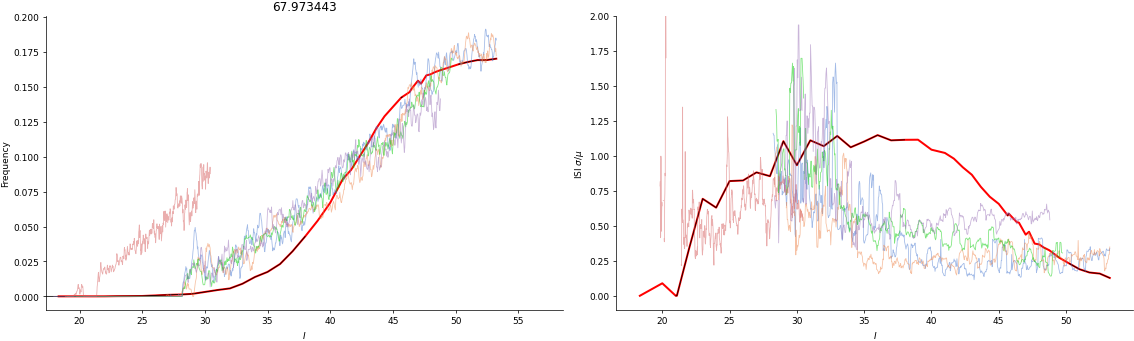

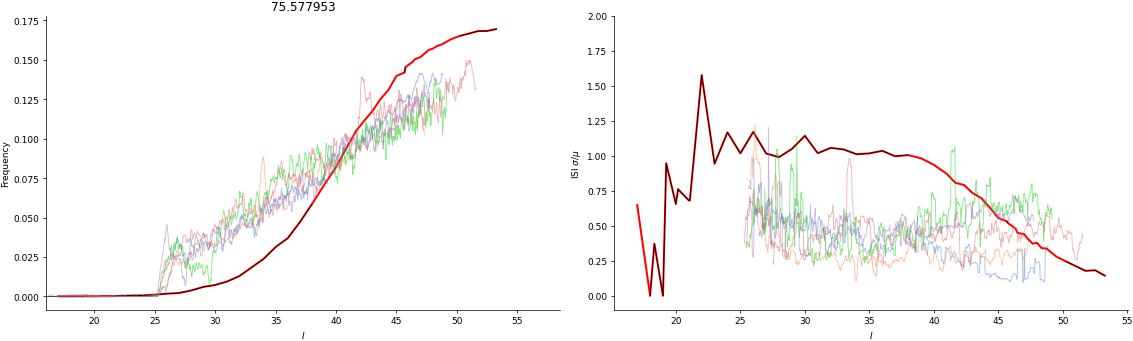

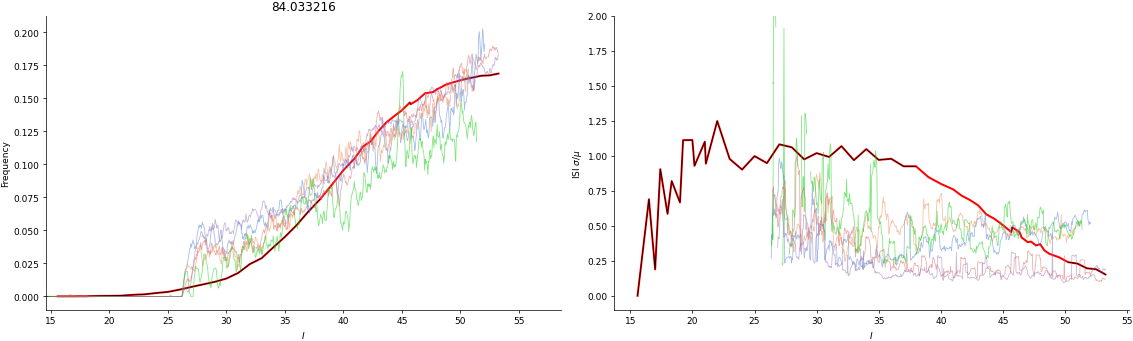

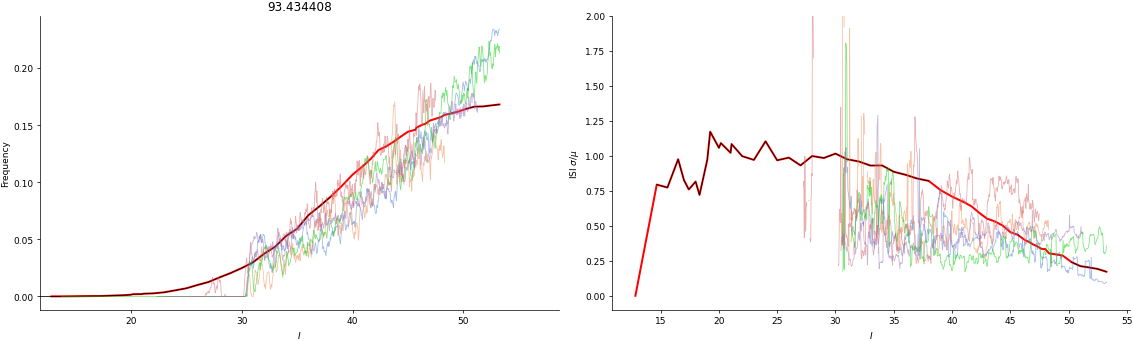

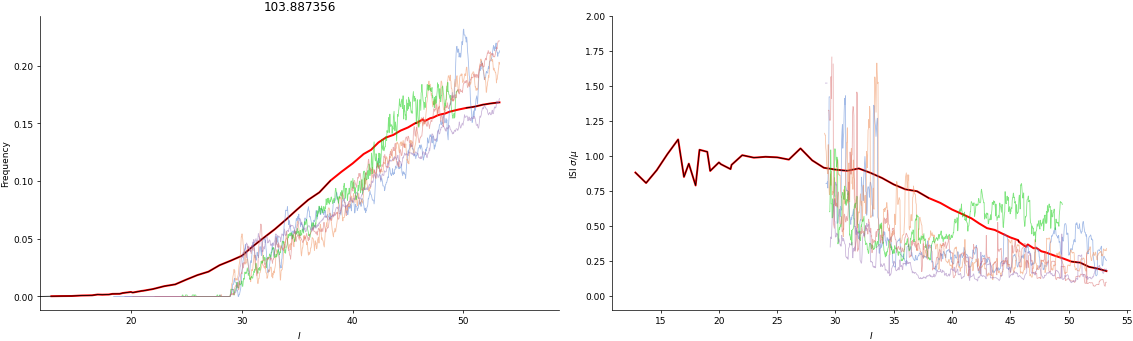

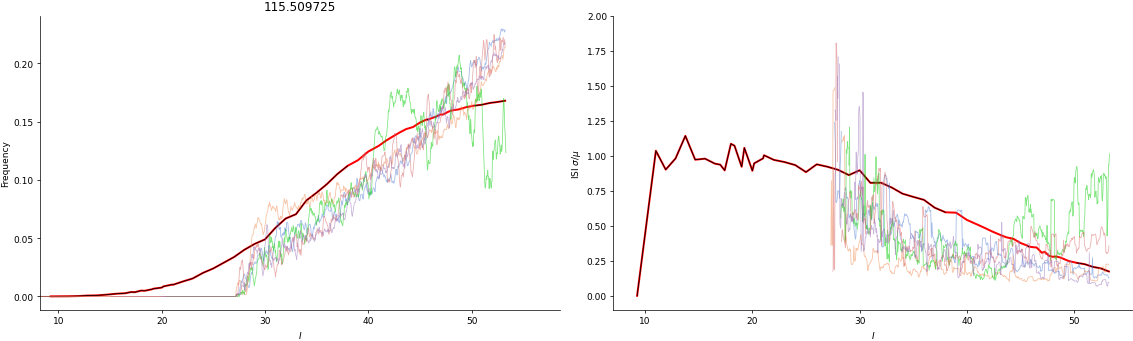

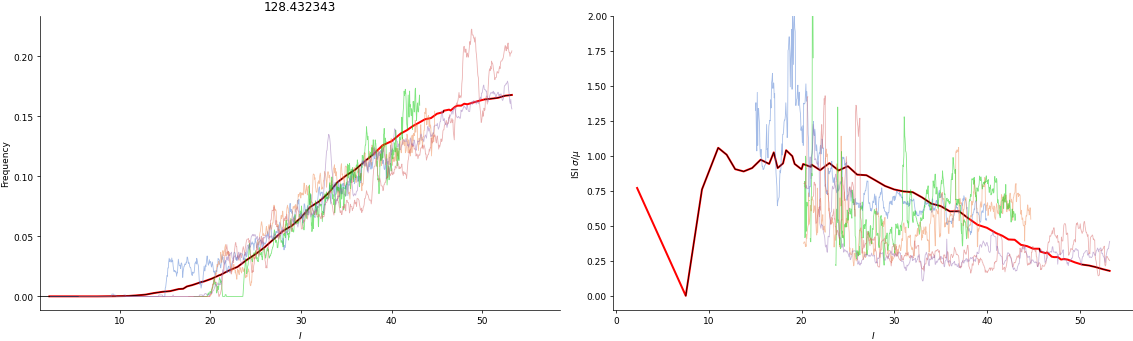

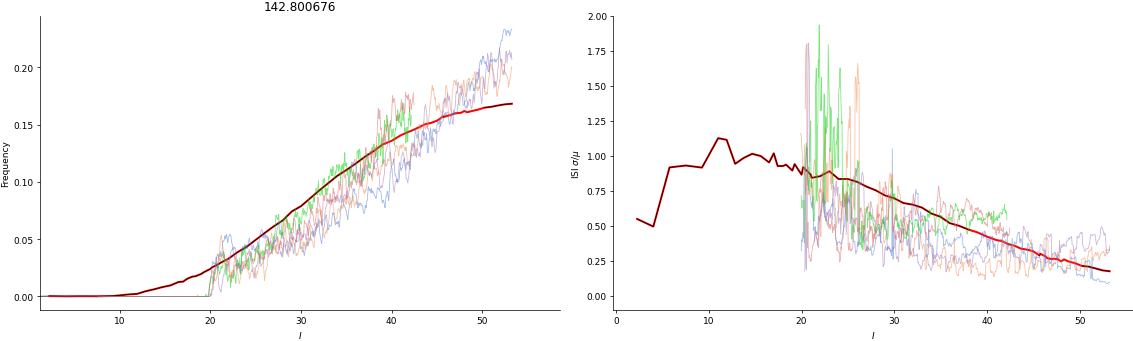

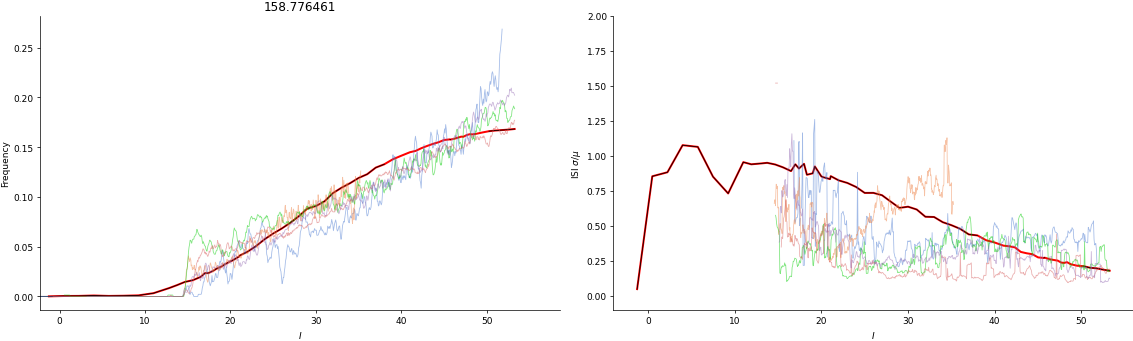

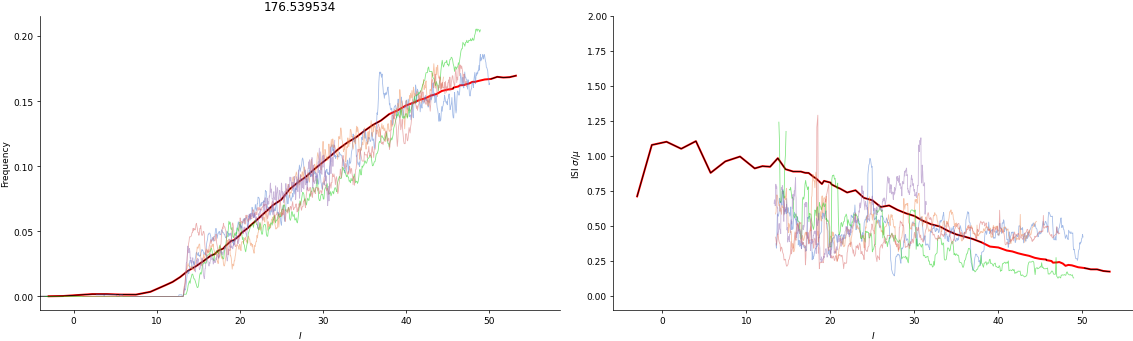

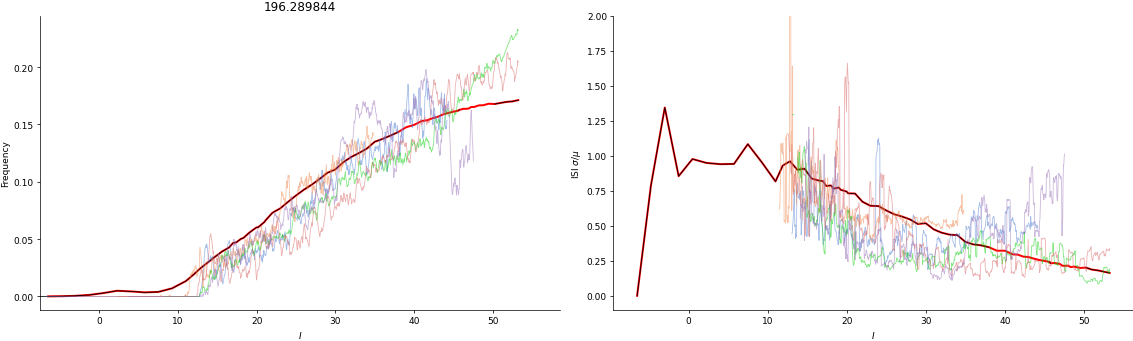

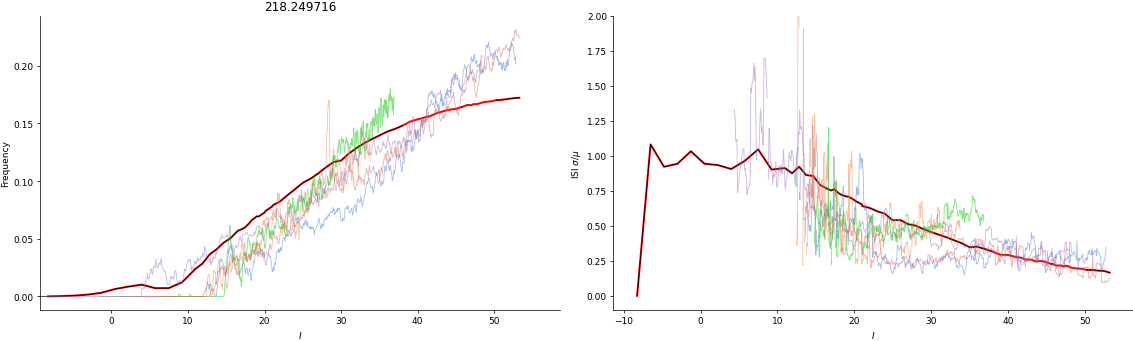

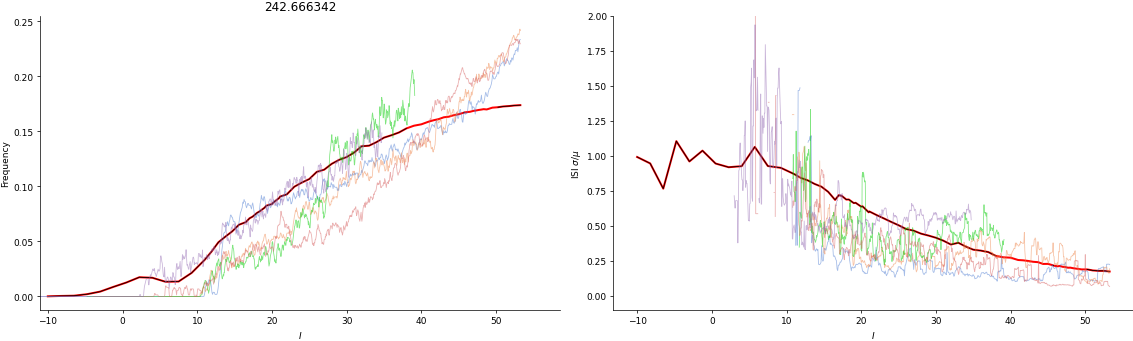

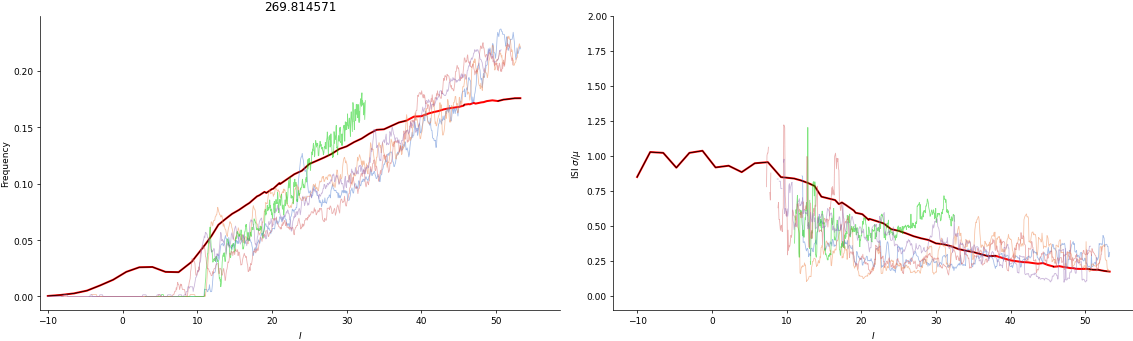

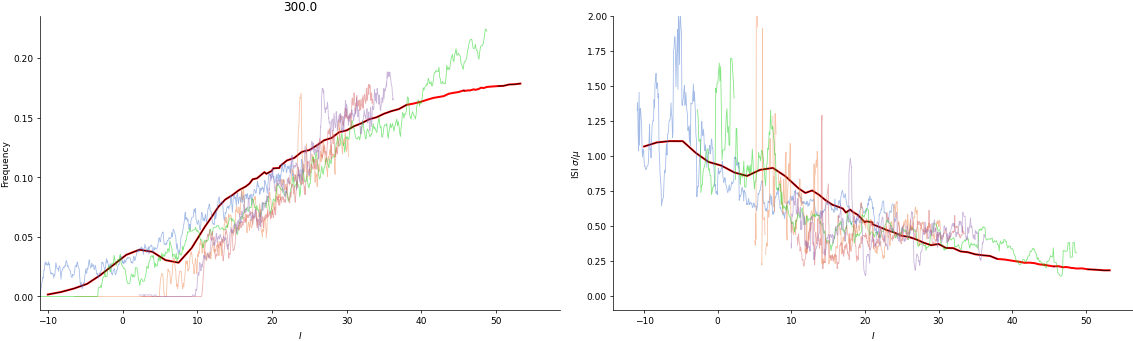

In [24]:
plt.close("all")
for row in range(f_sim.shape[0]):
# for row in range(20):
# for row in [7,8,9]:
    fig1, axes = plt.subplots(1, 2, figsize=(16,5))
    axes = axes.ravel()
    frequency = f_sim[row,:]
    cov = cov_sim[row,:]
    x_offset_post = 0
    xvals_data = np.arange(aligned_frequencies.shape[1])
    xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
                    beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post
    # sf0 = 500
    # xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/sf0*beta_nm[:,row,0][:,np.newaxis] +\
    #                 beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post

    if (sigmas[row] > 30) & (sigmas[row] < 80):
        print(sigmas[row])
        print(bounds[0,row,2]/scale_factors[2])
        
    dIdt = beta_nm[:,row,0]/scale_factors[0]/dt
    finite_mask = np.isfinite(frequency) & np.isfinite(cov)
    axes[0].plot(rs[finite_mask], frequency[finite_mask], color="red", linewidth=2)
    axes[1].plot(rs[finite_mask], cov[finite_mask], color="red", linewidth=2)
    axes[0].plot(rs, frequency, color="black")
    axes[1].plot(rs, cov, color="black")

    sorted_indices = np.random.choice(aligned_frequencies.shape[0], size=5, replace=False)
#     for e in [18,24,28]:
    for e in sorted_indices:
#     for e in np.arange(aligned_frequencies.shape[0]):
#         print(beta_nm[e,row,:])
#         print(bounds[e,row,:,:])
#         print(bounds[e,row,2,:]/scale_factors[2])
        f_expt = aligned_frequencies[e,:]
        cov_expt = aligned_covs[e,:]
        axes[0].plot(xvals_data_scaled[e], f_expt*beta_nm[e,row,1]/scale_factors[1], alpha=0.5, label="E%d" % e)
        axes[1].plot(xvals_data_scaled[e], cov_expt, alpha=0.5)
#     axes[0].legend()
    axes[0].set_xlabel(r"$I$")
    axes[1].set_xlabel(r"$I$")
    axes[0].set_ylabel("Frequency")
    axes[1].set_ylabel(r"ISI $\sigma/\mu$")
    xmax = 0.8
    axes[0].set_xlim((np.min(rs[finite_mask]) - 1, np.max(rs[finite_mask])*1.1))
    axes[0].set_title(sigmas[row])
    # axes[1].set_xlim((-0.5,xmax))
    # axes[0].set_ylim((-0.1,0.6))

    axes[1].set_ylim((-0.1, 2))
    plt.tight_layout()

In [57]:
cov_lookup(4)

array(0.62281221)

In [13]:
leastsquares = {}
bifurcations = ["snic", "saddle_node", "supercritical_hopf", "subcritical_hopf"]
for bif in bifurcations:
    q = np.load(os.path.join(figdir, "Data", "%s_individual_fits_randinit3.npz" % bif))
#     beta_nm = q["beta_nm"]
#     lstsq = np.ones(beta_nm.shape[:2]+ (2,))*np.nan
    scale_factors = scale_factors_bif[bif]
    beta_nm = q["beta_nm"]
    
    bif_data = all_data.loc[bif]
    f = pd.pivot_table(bif_data, values="freq", index="sigma", columns=["I"], dropna=False)
    covs = pd.pivot_table(bif_data, values="isi_cv", index="sigma", columns=["I"], dropna=False)
    sigmas = f.index.to_numpy()
    rs = f.columns.to_numpy()
    f_sim = f.to_numpy()
    cov_sim = covs.to_numpy()
    xvals_data = np.arange(aligned_frequencies.shape[1])
    err_nm = np.zeros_like(q["err_nm"])
    for row in range(len(sigmas)):

        fitfun, f_lookup, cov_lookup = sc_stats.gen_fitfun(rs, f_sim[row,:], cov_sim[row,:],\
                                                       540, 0, scale_factors, relweight=1,critical_point=None)

        for embryo in range(aligned_frequencies.shape[0]):
            f_expt = aligned_frequencies[embryo,:]
            cov_expt = aligned_covs[embryo,:]


            params = {}
            params['x_scale'] = beta_nm[embryo,row,0]
            params['amplitude'] = beta_nm[embryo,row,1]
            params['x_offset'] = beta_nm[embryo,row,2]
            
            res = fitfun(params, x = xvals_data, dat1=f_expt, dat2=cov_expt)**2
            err_nm[embryo, row] = np.nansum(res)


#     for sigma_idx in range(f_sim.shape[0]):
#         frequency = f_sim[sigma_idx]
#         cov = cov_sim[sigma_idx]
#         valid_sim_points = np.isfinite(frequency) & np.isfinite(cov)
#         interp_f = interpolate.interp1d(rs[valid_sim_points], frequency[valid_sim_points],\
#                                         fill_value=0, bounds_error=False)
#         interp_cov = interpolate.interp1d(rs[valid_sim_points], cov[valid_sim_points],\
#                                           fill_value=np.nanmax(cov[valid_sim_points]), bounds_error=False)

#         xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0] \
#                         *beta_nm[:,sigma_idx,0][:,np.newaxis] + beta_nm[:,sigma_idx,2][:,np.newaxis]/scale_factors[2]
#         y1_expt = beta_nm[:,sigma_idx,1][:,None]*aligned_frequencies/scale_factors[1]
#         y1_sim = interp_f(xvals_data_scaled)
#         sqdiff1 = ((y1_expt-y1_sim)*scale_factors[1])**2
#         n_samples1 = (~np.isnan(sqdiff1)).astype(int).sum(axis=1)

#         y2_expt = aligned_covs
#         y2_sim = interp_cov(xvals_data_scaled)
#         sqdiff2 = (y2_expt-y2_sim)**2
#         n_samples2 = (~np.isnan(sqdiff2)).astype(int).sum(axis=1)

#         lstsq[:, sigma_idx,0] = np.nansum(sqdiff1, axis=1)/n_samples1
#         lstsq[:, sigma_idx,1] = np.nansum(sqdiff2, axis=1)/n_samples2
#     leastsquares[bif] = lstsq
    leastsquares[bif] = np.copy(err_nm)
# lstsq[:,[44,45]] = np.nan
# np.savez(os.path.join(figdir, "../Data", "Figure2", "individual_lif_fits_lstsq.npz"), err_nm=lstsq, beta_nm=beta_nm, bounds=bounds)

snic


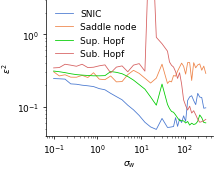

In [21]:
fig1, ax1 = plt.subplots(figsize=(3,2.5))
labels = ["SNIC", "Saddle node", "Sup. Hopf", "Sub. Hopf"]
mean_lstsq_bifs = []

global_min_lstsq = np.inf

for idx, bif in enumerate(bifurcations):
    lstsq = leastsquares[bif]
#     median_lstsq = np.nanmedian(np.sum(lstsq, axis=2), axis=0)
#     mean_lstsq = np.nanmean(np.sum(lstsq,axis=2), axis=0)
#     std_lstsq = np.nanstd(np.sum(lstsq, axis=2), axis=0)
    median_lstsq = np.nanmedian(lstsq, axis=0)
    mean_lstsq = np.nanmean(lstsq, axis=0)
    mean_lstsq_bifs.append(np.copy(mean_lstsq))
    std_lstsq = np.nanstd(lstsq, axis=0)
    valid_mask = np.ones_like(sigmas, dtype=bool)
    if np.nanmin(mean_lstsq) < global_min_lstsq:
        print(bif)
        global_min_lstsq = np.nanmin(mean_lstsq)

# ax1.plot(sigmas[valid_mask], median_lstsq[valid_mask])
#     if bif == "snic":
#         ax1.plot(sigmas[valid_mask], mean_lstsq[valid_mask]* (10/15)**2, label = labels[idx])
#     else:
    ax1.plot(sigmas[valid_mask], mean_lstsq[valid_mask], label = labels[idx])
#     ax1.fill_between(sigmas[valid_mask], mean_lstsq[valid_mask]-std_lstsq[valid_mask],\
#                      mean_lstsq[valid_mask]+std_lstsq[valid_mask], alpha=0.1)
# ax1.set_yscale("log")
ax1.legend()
ax1.set_xscale("log")
ax1.set_xlabel(r"$\sigma_w$")
ax1.set_ylabel(r"$\epsilon^2$")
ax1.set_yscale("log")
ax1.set_ylim(0.04,3)
plt.savefig(os.path.join(figdir, "Supplementary Figures", "MorrisLecar_Single", "MSE_noise_zoom.svg"))

# ax1.set_xlim(0, 21)

In [37]:
mean_lstsq_bifs = np.array(mean_lstsq_bifs)

In [49]:
np.nanargmin(mean_lstsq_bifs[0])

18

In [47]:
mean_lstsq_bifs[:,18]

array([0.0488058 , 0.2489165 , 0.10545218, 0.90995391])

In [51]:
np.nanmin((mean_lstsq_bifs[1:]/mean_lstsq_bifs[0]), axis=0)[17]

2.588601889524692

In [43]:
sigmas[18]

22.220123

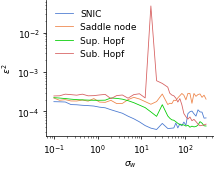

In [26]:
fig1, ax1 = plt.subplots(figsize=(3,2.5))
labels = ["SNIC", "Saddle node", "Sup. Hopf", "Sub. Hopf"]
for idx, bif in enumerate(bifurcations):
    lstsq = leastsquares[bif]
#     median_lstsq = np.nanmedian(np.sum(lstsq, axis=2), axis=0)
#     mean_lstsq = np.nanmean(np.sum(lstsq,axis=2), axis=0)
#     std_lstsq = np.nanstd(np.sum(lstsq, axis=2), axis=0)
    median_lstsq = np.nanmedian(lstsq, axis=0)
    mean_lstsq = np.nanmean(lstsq, axis=0)
    std_lstsq = np.nanstd(lstsq, axis=0)
    valid_mask = np.ones_like(sigmas, dtype=bool)

# ax1.plot(sigmas[valid_mask], median_lstsq[valid_mask])
#     if bif == "snic":
#         ax1.plot(sigmas[valid_mask], mean_lstsq[valid_mask]* (10/15)**2, label = labels[idx])
#     else:
    ax1.plot(sigmas[valid_mask], mean_lstsq[valid_mask], label = labels[idx])
#     ax1.fill_between(sigmas[valid_mask], mean_lstsq[valid_mask]-std_lstsq[valid_mask],\
#                      mean_lstsq[valid_mask]+std_lstsq[valid_mask], alpha=0.1)
# ax1.set_yscale("log")
ax1.legend()
ax1.set_xscale("log")
ax1.set_xlabel(r"$\sigma_w$")
ax1.set_ylabel(r"$\epsilon^2$")
ax1.set_yscale("log")
# ax1.set_ylim(0.05,5)
# plt.savefig(os.path.join(figdir, "Supplementary Figures", "MorrisLecar_Single", "MSE_noise.svg"))

# ax1.set_xlim(0, 21)

In [27]:
plt.close("all")

In [29]:
beta_nm[:,:,0].shape

(39, 40)

In [45]:
dt*3600

17.64705882352615

snic
saddle_node
supercritical_hopf
subcritical_hopf


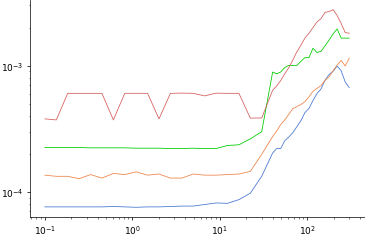

In [48]:

fig1, ax1 = plt.subplots(figsize=(6,4))
for bif in bifurcations:
    print(bif)
    q = np.load(os.path.join(figdir, "Data", "%s_individual_fits_randinit3.npz" % bif))
    beta_nm = q["beta_nm"]
    bounds = q["bounds"]

    bif_data = all_data.loc[bif]
    f = pd.pivot_table(bif_data, values="freq", index="sigma", columns=["I"], dropna=False)
    covs = pd.pivot_table(bif_data, values="isi_cv", index="sigma", columns=["I"], dropna=False)
    sigmas = f.index.to_numpy()
    rs = f.columns.to_numpy()
    f_sim = f.to_numpy()
    cov_sim = covs.to_numpy()
    scale_factors = scale_factors_bif[bif]


#     xvals_data = np.arange(aligned_frequencies.shape[1])
#     for row in range(f_sim.shape[0]):
#         x_offset_post = 0
#         xvals_data = np.arange(aligned_frequencies.shape[1])
#         xvals_data_scaled = (np.tile(xvals_data, (aligned_frequencies.shape[0],1))-540)/scale_factors[0]*beta_nm[:,row,0][:,np.newaxis] +\
#                         beta_nm[:,row,2][:,np.newaxis]/scale_factors[2] + x_offset_post
    dIdi = beta_nm[:,:,0]/scale_factors[0]
    didt = 1/(dt*3600)
    dIdt = dIdi*didt
    ax1.plot(sigmas, np.median(dIdt, axis=0))
ax1.set_yscale("log")
ax1.set_xscale("log")

In [42]:
xvals_data_scaled

array([[-17.04873927, -17.03690622, -17.02507316, ...,   1.87231782,
          1.88415087,   1.89598393],
       [-17.04873927, -17.03690622, -17.02507316, ...,   1.87231782,
          1.88415087,   1.89598393],
       [-18.03946508, -18.0254834 , -18.01150172, ...,   4.31723874,
          4.33122042,   4.3452021 ],
       ...,
       [-17.04873927, -17.03690622, -17.02507316, ...,   1.87231782,
          1.88415087,   1.89598393],
       [-17.24776502, -17.23556339, -17.22336177, ...,   2.26263251,
          2.27483413,   2.28703576],
       [-17.04873927, -17.03690622, -17.02507316, ...,   1.87231782,
          1.88415087,   1.89598393]])

In [35]:
xvals_data

array([   0,    1,    2, ..., 1599, 1600, 1601])

Redo new

In [2]:
rootdir = Path(ANALYSIS_OUTPUT_ROOTDIR, "2022 First Heartbeat_Submitted",
    "Figures/Data/Figure2/MorrisLecar_fits")
os.makedirs(rootdir, exist_ok=True)

In [3]:
leastsquares = {}
bifurcations = ["snic", "saddle_node", "supercritical_hopf", "subcritical_hopf"]
for bif in bifurcations:
    q = np.load(rootdir/f"{bif}_individual_fits_randinit3.npz")
    leastsquares[bif] = q["err_nm"]


In [7]:
list(q.keys())

['err_nm', 'beta_nm', 'bounds']

In [8]:
leastsquares["snic"].shape

(39, 40)

ERROR! Session/line number was not unique in database. History logging moved to new session 2722


In [16]:
lstsq.shape

(39, 40)

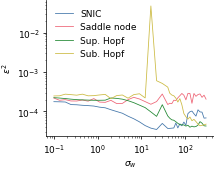

In [21]:
fig1, ax1 = plt.subplots(figsize=(3,2.5))
labels = ["SNIC", "Saddle node", "Sup. Hopf", "Sub. Hopf"]
error_dfs = {}
for idx, bif in enumerate(bifurcations):
    lstsq = leastsquares[bif]
#     median_lstsq = np.nanmedian(np.sum(lstsq, axis=2), axis=0)
#     mean_lstsq = np.nanmean(np.sum(lstsq,axis=2), axis=0)
#     std_lstsq = np.nanstd(np.sum(lstsq, axis=2), axis=0)
    median_lstsq = np.nanmedian(lstsq, axis=0)
    mean_lstsq = np.nanmean(lstsq, axis=0)
    std_lstsq = np.nanstd(lstsq, axis=0)
    valid_mask = np.ones_like(sigmas, dtype=bool)
    error_df = pd.DataFrame(lstsq.T, columns=[f"embryo_{i}" for i in range(lstsq.shape[0])])
    error_df["bifurcation"] = bif
    error_df["sigma"] = sigmas
    error_dfs[bif] = error_df

# ax1.plot(sigmas[valid_mask], median_lstsq[valid_mask])
#     if bif == "snic":
#         ax1.plot(sigmas[valid_mask], mean_lstsq[valid_mask]* (10/15)**2, label = labels[idx])
#     else:
    ax1.plot(sigmas[valid_mask], mean_lstsq[valid_mask], label = labels[idx])
#     ax1.fill_between(sigmas[valid_mask], mean_lstsq[valid_mask]-std_lstsq[valid_mask],\
#                      mean_lstsq[valid_mask]+std_lstsq[valid_mask], alpha=0.1)
# ax1.set_yscale("log")
ax1.legend()
ax1.set_xscale("log")
ax1.set_xlabel(r"$\sigma_w$")
ax1.set_ylabel(r"$\epsilon^2$")
ax1.set_yscale("log")

In [23]:
for bif in bifurcations:
    error_dfs[bif].to_csv(rootdir/f"errors_{bif}.csv")